In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier

import random
import numpy as np
import torch

from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader, random_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/mnt/storageG1/lwang/miniconda3/envs/new-ml/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Using device: cuda


In [2]:
import os
import random
import numpy as np

# If using PyTorch
import torch

# If using TensorFlow

# Optional: If using Python hash-based functions
os.environ["PYTHONHASHSEED"] = "42"

# Set seed for base Python random
random.seed(42)

# Set seed for NumPy
np.random.seed(42)

# Set seed for PyTorch (CPU and GPU)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # if using multi-GPU

# Force deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
# # Manual FASTA parsing (without Biopython)
# fasta_path = "../data//naturalAMPs_APD2024a-ADAM.fasta.txt"

# # Read lines from the FASTA file
# with open(fasta_path, "r") as f:
#     lines = f.read().strip().splitlines()

# # Parse into (ID, Sequence) pairs
# records = []
# current_id = None
# current_seq = []
# for line in lines:
#     if line.startswith(">"):
#         if current_id is not None:
#             records.append([current_id, ''.join(current_seq)])
#         current_id = line[1:].strip()
#         current_seq = []
#     else:
#         current_seq.append(line.strip())

# # Add the last record
# if current_id is not None:
#     records.append([current_id, ''.join(current_seq)])

# # Convert to DataFrame
# df_fasta_manual = pd.DataFrame(records, columns=["Peptide ID", "Sequence"])
# df_fasta_manual.to_csv("../data/naturalAMPs_APD2024a-ADAM.csv", index=False)


# Manual FASTA parsing (without Biopython)
# fasta_path = "../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta"

# # Read lines from the FASTA file
# with open(fasta_path, "r") as f:
#     lines = f.read().strip().splitlines()

# # Parse into (ID, Sequence) pairs
# records = []
# current_id = None
# current_seq = []
# for line in lines:
#     if line.startswith(">"):
#         if current_id is not None:
#             records.append([current_id, ''.join(current_seq)])
#         current_id = line[1:].strip()
#         current_seq = []
#     else:
#         current_seq.append(line.strip())

# # Add the last record
# if current_id is not None:
#     records.append([current_id, ''.join(current_seq)])

# # Convert to DataFrame
# df_fasta_manual = pd.DataFrame(records, columns=["Peptide ID", "Sequence"])
# df_fasta_manual.to_csv("../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta.csv", index=False)



# fasta_path = "../data/uniprotkb_length_5_TO_30_NOT_antimicrob_2025_04_14.fasta (1)"

# # Read lines from the FASTA file
# with open(fasta_path, "r") as f:
#     lines = f.read().strip().splitlines()

# # Parse into (ID, Sequence) pairs
# records = []
# current_id = None
# current_seq = []
# for line in lines:
#     if line.startswith(">"):
#         if current_id is not None:
#             records.append([current_id, ''.join(current_seq)])
#         current_id = line[1:].strip()
#         current_seq = []
#     else:
#         current_seq.append(line.strip())

# # Add the last record
# if current_id is not None:
#     records.append([current_id, ''.join(current_seq)])

# # Convert to DataFrame
# df_fasta_manual = pd.DataFrame(records, columns=["Peptide ID", "Sequence"])
# df_fasta_manual.to_csv("../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta1.csv", index=False)

## Data

In [4]:
# from Bio import SeqIO

# def read_fasta_sequences(fasta_path):
#     """
#     Reads sequences from a FASTA file and returns them as a list of strings.

#     Args:
#         fasta_path (str): Path to the FASTA file.

#     Returns:
#         List[str]: A list of amino acid or nucleotide sequences as strings.
#     """
#     sequences = [str(record.seq) for record in SeqIO.parse(fasta_path, "fasta")]
#     return sequences

In [5]:
dbbasp = pd.read_csv("../models1/database_check/DBAASP_peptides.csv")
dbbasp = dbbasp[dbbasp["SEQUENCE"].str.len() >= 10]
dbbasp = dbbasp[~dbbasp["TARGET GROUP"].str.contains("Fungus", na=False)]
dbbasp = dbbasp[["ID", "SEQUENCE"]]
dbbasp.columns = ["Peptide ID", "Sequence"]
adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df = pd.concat([adam_df, dbbasp], ignore_index=True)
uniprot_df = pd.read_csv("../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta.csv")
uniprot_df1 = pd.read_csv("../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta1.csv")
uniprot_df2 = pd.read_csv("/mnt/storageG1/lwang/Projects/TB-AMP-design/data/uniprotkb_length_5_TO_30_NOT_antimicrob_2025_04_23 (1).tsv", sep="\t")
uniprot_df2
uniprot_df2 = uniprot_df2[['Entry', 'Sequence']]
uniprot_df2.columns = ["Peptide ID", "Sequence"]
uniprot_df = pd.concat([uniprot_df, uniprot_df1, uniprot_df2], ignore_index=True)

In [6]:
uniprot_df = uniprot_df[uniprot_df['Sequence'].apply(lambda s: isinstance(s, str) and len(s) >= 10)]
uniprot_df = uniprot_df.drop_duplicates(subset="Sequence")
uniprot_df

,Peptide ID,Sequence
0,tr|A0A009HCC0|A0A009HCC0_9GAMM Acyl carrier pr...,MSDIEQRVKQAVAEQLGLKAEEIKNEASFMDDLGADSLDLVELVMS...
6,tr|A0A009YF97|A0A009YF97_9GAMM Acyl carrier pr...,MSDIEQRVKQAVAEQLGMKVEEIKNEASFMDDLGADSLDLVELVMS...
8,tr|A0A010SZ96|A0A010SZ96_PSEFL Acyl carrier pr...,MSTIEERVKKIVAEQLGVKEEEVVNTASFVEDLGADSLDTVELVMA...
9,tr|A0A011NAB1|A0A011NAB1_9PAST Acyl carrier pr...,MSIEERVKKIIVDQLGAKAEDVKPEASFIEDLGADSLDTVELVMAL...
10,tr|A0A011NTH9|A0A011NTH9_9PROT DNA-directed RN...,MARVTVDDCLTRIPNRFQMTLAATYRARQITAGASPLIDANRDKPT...
...,...,...
104968,P9WEJ1,MPEQKANCSPNGNITVDSMIMSLGSS
105566,Q6LEB3,LFNKYISRPRRVELAVMLNLTERHIKI
105568,Q6QLL8,VKGFSFKYGNGVWIGRTKSTNSRSGFQ
105789,Q9DTV7,HFPGFGQSLLFGYPVYVFGDCVQGDWCR


In [7]:

# Remove rows where the Sequence is not a string or is shorter than 10 characters
adam_df = adam_df[adam_df['Sequence'].apply(lambda x: isinstance(x, str) and len(x) >= 10)]

190 10
Range of sequence lengths: 180


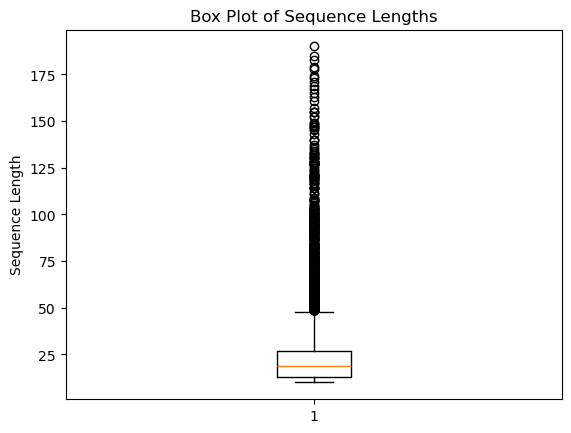

Mean sequence length: 23.215054249547922
Median sequence length: 19.0
Standard deviation of sequence lengths: 15.467236594869847


In [8]:
import matplotlib.pyplot as plt

# Calculate sequence lengths
sequence_lengths = adam_df['Sequence'].apply(len)

# Calculate the range of sequence lengths
length_range = sequence_lengths.max() - sequence_lengths.min()
print(sequence_lengths.max(),sequence_lengths.min())
print(f"Range of sequence lengths: {length_range}")

# Draw a box plot
plt.boxplot(sequence_lengths)
plt.title("Box Plot of Sequence Lengths")
plt.ylabel("Sequence Length")
plt.show()

# Calculate and display distribution statistics
mean_length = sequence_lengths.mean()
median_length = sequence_lengths.median()
std_dev_length = sequence_lengths.std()

print(f"Mean sequence length: {mean_length}")
print(f"Median sequence length: {median_length}")
print(f"Standard deviation of sequence lengths: {std_dev_length}")

# adam_df = adam_df.drop(columns=['Sequence Length'])

/tmp/ipykernel_115197/679251586.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_uniprot_df = uniprot_df.groupby('Sequence Length', group_keys=False).apply(


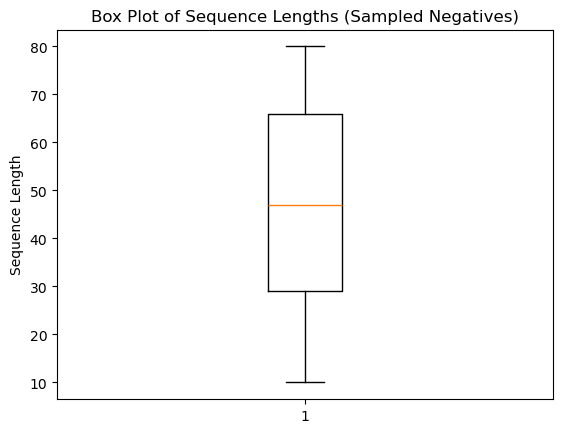

                                              Peptide ID  \
0      sp|C0HJE2|AMYG_BACLI Glucoamylase (Fragment) O...   
1      sp|Q03367|PSBF_CAPAN Cytochrome b559 subunit b...   
2      sp|Q10997|SPI_HALRO Serine proteinase inhibito...   
3      sp|P85962|RLA2_PSEMZ Large ribosomal subunit p...   
4      sp|P02728|GLEM_HUMAN Erythrocyte membrane glyc...   
...                                                  ...   
15376  tr|A0A497J933|A0A497J933_9ARCH DNA-directed RN...   
15377  tr|Q6Q0P4|Q6Q0P4_POLCT Cytochrome c oxidase su...   
15378  tr|A0A2J4G6H0|A0A2J4G6H0_9CREN DNA-directed RN...   
15379  tr|A0A327J0Z7|A0A327J0Z7_9BACT ATP synthase su...   
15380  tr|A0A0G2F2K3|A0A0G2F2K3_PHACM U6 snRNA-associ...   

                                                Sequence  
0                                             SSNKLTTSWG  
1                                             SISAMQFIQR  
2                                             TKKDGEEKVA  
3                                          

In [9]:
# Calculate sequence lengths for uniprot_df
uniprot_df['Sequence Length'] = uniprot_df['Sequence'].apply(len)

# Calculate sequence lengths for adam_df
adam_df['Sequence Length'] = adam_df['Sequence'].apply(len)

# Perform stratified sampling to select more samples
default_min_samples = 30

# Perform lenient stratified sampling
sampled_uniprot_df = uniprot_df.groupby('Sequence Length', group_keys=False).apply(
    lambda x: x.sample(
        n=min(
            len(x), 
            int(14 * adam_df['Sequence Length'].value_counts().get(x.name, default_min_samples))
        ),
        random_state=42
    )
).reset_index(drop=True)
# Drop the 'Sequence Length' column after sampling
sampled_uniprot_df = sampled_uniprot_df.drop(columns=['Sequence Length'])
adam_df = adam_df.drop(columns=['Sequence Length'])

# Draw a box plot to visualize the distribution
plt.boxplot(sampled_uniprot_df['Sequence'].apply(len))
plt.title("Box Plot of Sequence Lengths (Sampled Negatives)")
plt.ylabel("Sequence Length")
plt.show()

print(sampled_uniprot_df)

### data organization

In [10]:
adam_df['label'] = 1
sampled_uniprot_df['label'] = 0
adam_df.columns = ["Peptide ID", "Sequences", 'label']
sampled_uniprot_df.columns = ["Peptide ID", "Sequences" , 'label']
df = pd.concat([adam_df, sampled_uniprot_df], ignore_index=True)

max_length = df['Sequences'].str.len().max()
print(max_length)
# df['Sequences'] = df['Sequences'].apply(lambda x: x.ljust(max_length, 'X'))

unique_letters = set(''.join(df["Sequences"]))
print(unique_letters)
print(len(unique_letters))
amino_acids = set("ACDEFGHIKLMNPQRSTVWYX")
non_standard_amino_acids = unique_letters - amino_acids
print(non_standard_amino_acids)

# Filter out sequences containing non-standard amino acids
df = df[~df['Sequences'].str.contains('|'.join(non_standard_amino_acids))]
df = df.drop_duplicates(subset='Sequences')
tb_df = pd.read_csv('../data/all_seq702.csv')
df = df[~df['Sequences'].isin(tb_df['Sequences'])]
df = df[df['Sequences'].apply(lambda x: isinstance(x, str) and len(x) >= 10)]
print(f"Number of sequences after filtering: {len(df)}")
print(df['label'].value_counts())

unique_letters = set(''.join(df["Sequences"]))
print(unique_letters)
print(len(unique_letters))
amino_acids = set("ACDEFGHIKLMNPQRSTVWYX")
non_standard_amino_acids = unique_letters - amino_acids
print(non_standard_amino_acids)

X = df["Sequences"]
y = df["label"]

# Split into train (70%), validation (15%), test (15%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 2: Split train+val into train and val (stratified)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)  # 0.1765 to maintain 15% of original dataset




190
{'w', 'Q', 'R', 'G', 'T', '9', 'N', 'W', 'v', 'k', 'l', 'D', 'L', 'Y', 'm', 'F', 's', 'U', 'n', 'g', 'I', 'x', 'f', 'O', 'E', 'i', 'Z', 'X', 'a', 'K', 'B', 'P', ' ', 'y', 'h', 't', 'M', 'S', 'V', 'H', 'p', 'd', 'C', 'e', 'c', 'A', 'q', 'r'}
48
{'w', '9', 'v', 'l', 'k', 'm', 's', 'U', 'n', 'g', 'x', 'O', 'f', 'i', 'Z', 'a', 'B', ' ', 'h', 'y', 't', 'p', 'd', 'e', 'c', 'q', 'r'}
Number of sequences after filtering: 30987
label
1    15839
0    15148
Name: count, dtype: int64
{'Q', 'R', 'G', 'T', 'N', 'W', 'D', 'L', 'Y', 'F', 'I', 'E', 'X', 'K', 'P', 'M', 'S', 'V', 'H', 'C', 'A'}
21
set()


In [11]:
# lengths = [len(seq) for seq in df['Sequences']]
# print(lengths[lengths <= 0])

lengths = np.array([len(seq) for seq in df['Sequences']])
print(lengths[lengths <= 0])


[]


### dataset

In [12]:

# Define One-Hot Encoding Function for DNA Sequences in PyTorch
def one_hot_torch(seq: str, dtype=torch.float32):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
    aa_bytes = torch.ByteTensor(list(bytes(amino_acids, "utf-8")))
    arr = torch.zeros(len(amino_acids), len(seq_bytes), dtype=dtype)
    for i, aa in enumerate(aa_bytes):
        arr[i, seq_bytes == aa] = 1
    return arr


class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, one_hot_dtype=torch.float32):
        self.sequences = sequences
        self.labels = labels
        self.one_hot_dtype = one_hot_dtype

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences.iloc[idx]
        label = self.labels.iloc[idx]
        length = len(seq.replace("X", ""))  # unpadded length
        return one_hot_torch(seq, dtype=self.one_hot_dtype), torch.tensor(label, dtype=torch.float32), length

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

def collate_and_pack(batch):
    # batch = list of (tensor_seq, label, length)
    sequences, labels, lengths = zip(*batch)

    # Filter out sequences with zero length
    filtered_batch = [(seq, lbl, l) for seq, lbl, l in zip(sequences, labels, lengths) if l > 0]

    if len(filtered_batch) == 0:
        raise ValueError("All sequences in the batch have zero length.")

    sequences, labels, lengths = zip(*filtered_batch)

    # Convert lengths to tensor
    lengths = torch.tensor(lengths)

    # Sort by descending length (required by pack_padded_sequence)
    sorted_indices = torch.argsort(lengths, descending=True)
    sequences = [sequences[i] for i in sorted_indices]
    labels = torch.tensor([labels[i] for i in sorted_indices])
    lengths = lengths[sorted_indices]

    # Stack to shape: (batch_size, 20, seq_len) and transpose for LSTM input
    # LSTM expects input of shape (seq_len, batch_size, features)
    sequences = [seq.T for seq in sequences]  # Transpose each [20, L] to [L, 20]
    padded_seqs = pad_sequence(sequences, batch_first=False)  # shape: [max_len, batch, features]

    # Pack the sequence
    packed_input = pack_padded_sequence(padded_seqs, lengths.cpu(), batch_first=False)

    return packed_input, labels



In [13]:
# Define DataLoaders

train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)
test_dataset = SequenceDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_and_pack)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)

    
# Display dataset sizes
dataset_sizes = {
    "Train": len(train_dataset),
    "Validation": len(val_dataset),
    "Test": len(test_dataset)
}
print("Dataset sizes:")
for name, size in dataset_sizes.items():
    print(f"{name}: {size}")

Dataset sizes:
Train: 21690
Validation: 4649
Test: 4648


## testing

In [14]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0
        )

        # Classifier
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        # packed_input: PackedSequence
        packed_output, (hn, cn) = self.lstm(packed_input)

        # hn: [num_layers, batch_size, hidden_dim]
        # We'll use the **last layer's** hidden state as feature
        last_hidden = hn[-1]  # shape: [batch_size, hidden_dim]

        # Fully connected + sigmoid
        out = self.fc(last_hidden)       # shape: [batch_size, 1]
        out = self.sigmoid(out).squeeze(1)  # shape: [batch_size]
        return out


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score

from torch.utils.tensorboard import SummaryWriter
import datetime

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = 1000.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}

    # Set up TensorBoard writer
    log_dir = f"runs/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)

        # Run evaluation
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device)

        # Logging
        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

        # Save to history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), 'best_model.pt')

    writer.close()
    return history

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    # Convert predicted probabilities to binary predictions
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]

    # Metrics
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    # Confusion matrix
    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)  # handle corner cases

    # Sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        # Print metrics
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity (Recall for Positive Class): {sensitivity:.4f}")
        print(f"Specificity (Recall for Negative Class): {specificity:.4f}")

    return avg_loss, acc, auc


model = LSTMClassifier(hidden_dim=64)
history = train_model(model, train_loader, val_loader, num_epochs=10)


Epoch [1/10] - Train Loss: 0.5523, Val Loss: 0.6706, Val Acc: 0.5627, Val AUC: 0.7061
Epoch [2/10] - Train Loss: 0.4765, Val Loss: 0.3772, Val Acc: 0.8621, Val AUC: 0.9378


KeyboardInterrupt: 

### adding in regularization

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0  # LSTM dropout applies only between layers
        )

        # Dropout after LSTM (even if 1 layer)
        self.dropout = nn.Dropout(dropout)

        # Fully connected classifier
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        packed_output, (hn, cn) = self.lstm(packed_input)

        # Get the last hidden state from the last layer
        last_hidden = hn[-1]  # shape: [batch_size, hidden_dim]

        # Apply dropout
        dropped = self.dropout(last_hidden)

        # Fully connected + sigmoid
        out = self.fc(dropped)       # shape: [batch_size, 1]
        out = self.sigmoid(out).squeeze(1)  # shape: [batch_size]
        return out


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # L2 regularization

    best_val_loss = 1000.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}

    # Set up TensorBoard writer
    log_dir = f"runs/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)   
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)

        # Run evaluation
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        # Logging
        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        print(f"Epoch [{epoch}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, "
              f"Val AUC: {val_auc:.4f}")

        # Save to history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')

    writer.close()
    return history



from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    # Convert predicted probabilities to binary predictions
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]

    # Metrics
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    # Confusion matrix
    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)  # handle corner cases

    # Sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        # Print metrics
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity (Recall for Positive Class): {sensitivity:.4f}")
        print(f"Specificity (Recall for Negative Class): {specificity:.4f}")

    return avg_loss, acc, auc

model = LSTMClassifier(input_dim=20, hidden_dim=64, dropout=0.5)
history = train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3,
                      weight_decay=1e-4, verbose=True)



Confusion Matrix:
[[1786  487]
 [  74 2302]]
Sensitivity (Recall for Positive Class): 0.9689
Specificity (Recall for Negative Class): 0.7857
Epoch [1/10] - Train Loss: 0.4703, Val Loss: 0.3289, Val Acc: 0.8793, Val AUC: 0.9427

Confusion Matrix:
[[  12 2261]
 [   1 2375]]
Sensitivity (Recall for Positive Class): 0.9996
Specificity (Recall for Negative Class): 0.0053
Epoch [2/10] - Train Loss: 0.3643, Val Loss: 0.8430, Val Acc: 0.5134, Val AUC: 0.6575

Confusion Matrix:
[[1877  396]
 [ 438 1938]]
Sensitivity (Recall for Positive Class): 0.8157
Specificity (Recall for Negative Class): 0.8258
Epoch [3/10] - Train Loss: 0.6831, Val Loss: 0.6017, Val Acc: 0.8206, Val AUC: 0.8942

Confusion Matrix:
[[2173  100]
 [ 471 1905]]
Sensitivity (Recall for Positive Class): 0.8018
Specificity (Recall for Negative Class): 0.9560
Epoch [4/10] - Train Loss: 0.4295, Val Loss: 0.3204, Val Acc: 0.8772, Val AUC: 0.9526

Confusion Matrix:
[[2082  191]
 [ 212 2164]]
Sensitivity (Recall for Positive Class): 0

## Modelling on general AMP data (bayesian optimization)

### LSTM

In [16]:

import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime


class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        packed_output, (hn, cn) = self.lstm(packed_input)
        last_hidden = hn[-1]
        dropped = self.dropout(last_hidden)
        out = self.fc(dropped)
        out = self.sigmoid(out).squeeze(1)
        return out


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    # if not train:
    #     model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm_.pt')

    writer.close()
    return best_val_loss



def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc


def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2)

    model = LSTMClassifier(input_dim=20, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
    val_auc = train_model(model, train_loader, val_loader, num_epochs=20, lr=lr,
                          weight_decay=weight_decay, verbose=False, train=True)
    return val_auc


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_trial.params)
lstm_best_param = study.best_trial.params

/mnt/storageG1/lwang/miniconda3/envs/new-ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-06 10:43:08,155] A new study created in memory with name: no-name-32ca120b-d518-4e44-9e08-f233d31b1450
[I 2025-05-06 10:48:27,944] Trial 0 finished with value: 0.19858369925250746 and parameters: {'hidden_dim': 70, 'num_layers': 1, 'dropout': 0.38027966645972233, 'lr': 0.003241504883125835, 'weight_decay': 0.005328877972977425}. Best is trial 0 with value: 0.19858369925250746.
[I 2025-05-06 10:56:22,612] Trial 1 finished with value: 0.6929278202252845 and parameters: {'hidden_dim': 82, 'num_layers': 3, 'dropout': 0.18799202663891307, 'lr': 0.009958285769135185, 'weight_decay': 0.0033994716252035875}. Best is trial 0 with value: 0.19858369925250746.
[I 2025-05-06 11:01:34,172] Trial 2 finished with valu

Best hyperparameters: {'hidden_dim': 48, 'num_layers': 2, 'dropout': 0.1305874628402517, 'lr': 0.00421054415111712, 'weight_decay': 1.1250678718516062e-05}


#### testing

In [17]:
df = pd.read_csv('../data/all_seq702.csv')
df = df.drop_duplicates(subset='Sequences')
max_length = df['Sequences'].str.len().max()
print(max_length)
# df['Sequences'] = df['Sequences'].apply(lambda x: x.ljust(max_length, 'X'))

unique_letters = set(''.join(df["Sequences"]))
print(unique_letters)
print(len(unique_letters))
amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
non_standard_amino_acids = unique_letters - amino_acids
print(non_standard_amino_acids)
b_count = df["Sequences"].str.count('B').sum()
print(f"Number of 'B' values: {b_count}")
# manually replaced one of the B with D and the other with N

df = df[
    (df['Sequences'].str.len() >= 10) &
    (df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~df['Sequences'].str.contains('X'))
]

X = df["Sequences"]
y = df["AMP"]


# Split into train (70%), validation (15%), test (15%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Step 2: Split train+val into train and val (stratified)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)  # 0.1765 to maintain 15% of original dataset

# Define DataLoaders


test_dataset = SequenceDataset(X_test, y_test)

batch_size = 32

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)

    
# Display dataset sizes
dataset_sizes = {
    "Train": len(train_dataset),
    "Validation": len(val_dataset),
    "Test": len(test_dataset)
}
print("Dataset sizes:")
for name, size in dataset_sizes.items():
    print(f"{name}: {size}")

128
{'R', 'Q', 'G', 'T', 'N', 'W', 'D', 'L', 'Y', 'F', 'I', 'E', 'X', 'K', 'P', 'M', 'S', 'V', 'H', 'C', 'A'}
21
{'X'}
Number of 'B' values: 0
Dataset sizes:
Train: 21690
Validation: 4649
Test: 88


In [18]:
test_loader

In [19]:
# model = LSTMClassifier(input_dim=20, hidden_dim=47, num_layers=2, dropout=0.18950252633567022)
# history = train_model(model, train_loader, val_loader, num_epochs=19, lr=0.009528266081905703,
#                       weight_decay=1.1052415577383506e-05, verbose=True)

model = LSTMClassifier(input_dim=20, hidden_dim=lstm_best_param['hidden_dim'], num_layers=lstm_best_param['num_layers'], dropout= lstm_best_param['dropout'])
history = train_model(model, train_loader, val_loader, num_epochs=20, lr=lstm_best_param['lr'],
                      weight_decay=lstm_best_param['weight_decay'], verbose=True)
criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

torch.save(model.state_dict(), 'best_model_lstm_1.pt')


Confusion Matrix:
[[2019  254]
 [ 190 2186]]
Sensitivity: 0.9200, Specificity: 0.8883
Epoch [1/20] - Train Loss: 0.3328, Val Loss: 0.2347, Val Acc: 0.9045, Val AUC: 0.9667



Confusion Matrix:
[[2085  188]
 [ 230 2146]]
Sensitivity: 0.9032, Specificity: 0.9173
Epoch [2/20] - Train Loss: 0.2288, Val Loss: 0.2179, Val Acc: 0.9101, Val AUC: 0.9722

Confusion Matrix:
[[1868  405]
 [  64 2312]]
Sensitivity: 0.9731, Specificity: 0.8218
Epoch [3/20] - Train Loss: 0.2147, Val Loss: 0.2132, Val Acc: 0.8991, Val AUC: 0.9772

Confusion Matrix:
[[2047  226]
 [ 120 2256]]
Sensitivity: 0.9495, Specificity: 0.9006
Epoch [4/20] - Train Loss: 0.1980, Val Loss: 0.1859, Val Acc: 0.9256, Val AUC: 0.9800

Confusion Matrix:
[[1998  275]
 [  87 2289]]
Sensitivity: 0.9634, Specificity: 0.8790
Epoch [5/20] - Train Loss: 0.1839, Val Loss: 0.1846, Val Acc: 0.9221, Val AUC: 0.9813

Confusion Matrix:
[[2129  144]
 [ 186 2190]]
Sensitivity: 0.9217, Specificity: 0.9366
Epoch [6/20] - Train Loss: 0.1705, Val Loss: 0.1628, Val Acc: 0.9290, Val AUC: 0.9840

Confusion Matrix:
[[2139  134]
 [ 175 2201]]
Sensitivity: 0.9263, Specificity: 0.9410
Epoch [7/20] - Train Loss: 0.1637, Val Loss: 0.1

### biLSTM

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime

class BiLSTMWithFlattenClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3, max_seq_len=100):
        super(BiLSTMWithFlattenClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.max_seq_len = max_seq_len

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(max_seq_len * hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        batch_size, seq_len, feature_dim = lstm_out.size()

        if seq_len < self.max_seq_len:
            pad_len = self.max_seq_len - seq_len
            pad = torch.zeros(batch_size, pad_len, feature_dim, device=lstm_out.device)
            lstm_out = torch.cat([lstm_out, pad], dim=1)
        elif seq_len > self.max_seq_len:
            lstm_out = lstm_out[:, :self.max_seq_len, :]

        dropped = self.dropout(lstm_out)
        flat = dropped.contiguous().view(batch_size, -1)
        out = self.fc(flat)
        return self.sigmoid(out).squeeze(1)

# Evaluation function
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000.0

    log_dir = f"runs-bilstm_flatten/BiLSTM_Flatten_Optuna_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model-bilstm.pt')

    writer.close()
    return best_val_loss

# Optuna objective function
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2)
    max_seq_len = 100  # fixed for now; match your padding/truncation

    model = BiLSTMWithFlattenClassifier(
        input_dim=20,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout,
        max_seq_len=max_seq_len
    )

    val_auc = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=10,
        lr=lr,
        weight_decay=weight_decay,
        verbose=False
    )
    return val_auc

# Usage (uncomment and run in your local environment):
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_best_param = study.best_trial.params

[I 2025-05-06 13:01:52,568] A new study created in memory with name: no-name-cc2f9fcd-612f-4e1c-94f8-b25d25b2d816


[I 2025-05-06 13:05:12,340] Trial 0 finished with value: 0.2066231785367613 and parameters: {'hidden_dim': 125, 'num_layers': 3, 'dropout': 0.12023824200443928, 'lr': 0.003031862918182845, 'weight_decay': 0.0051651622324290734}. Best is trial 0 with value: 0.2066231785367613.
[I 2025-05-06 13:07:43,189] Trial 1 finished with value: 0.1317762613602697 and parameters: {'hidden_dim': 85, 'num_layers': 2, 'dropout': 0.19156042992307892, 'lr': 0.006572817643613217, 'weight_decay': 0.00025478805676431063}. Best is trial 1 with value: 0.1317762613602697.
[I 2025-05-06 13:10:35,908] Trial 2 finished with value: 0.14464848713107306 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.29513474079209534, 'lr': 0.00615706450445208, 'weight_decay': 0.0004853969475302689}. Best is trial 1 with value: 0.1317762613602697.
[I 2025-05-06 13:12:59,525] Trial 3 finished with value: 0.18360891693258938 and parameters: {'hidden_dim': 118, 'num_layers': 1, 'dropout': 0.1730863015776694, 'lr': 0.

Best hyperparameters: {'hidden_dim': 100, 'num_layers': 2, 'dropout': 0.20840654476885606, 'lr': 0.007257394353633846, 'weight_decay': 1.0693673700535341e-05}


In [21]:
# bilstm_best_param = {'hidden_dim': 59, 'num_layers': 1, 'dropout': 0.19595557432276017, 'lr': 0.009816503475479747, 'weight_decay': 2.600777275437832e-05}

In [22]:
df = pd.read_csv('../data/all_seq702.csv')
df = df.drop_duplicates(subset='Sequences')
max_length = df['Sequences'].str.len().max()
print(max_length)
# df['Sequences'] = df['Sequences'].apply(lambda x: x.ljust(max_length, 'X'))

unique_letters = set(''.join(df["Sequences"]))
print(unique_letters)
print(len(unique_letters))
amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
non_standard_amino_acids = unique_letters - amino_acids
print(non_standard_amino_acids)
b_count = df["Sequences"].str.count('B').sum()
print(f"Number of 'B' values: {b_count}")
# manually replaced one of the B with D and the other with N

df = df[
    (df['Sequences'].str.len() >= 10) &
    (df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~df['Sequences'].str.contains('X'))
]

X = df["Sequences"]
y = df["AMP"]


# Split into train (70%), validation (15%), test (15%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Step 2: Split train+val into train and val (stratified)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)  # 0.1765 to maintain 15% of original dataset

# Define DataLoaders


test_dataset = SequenceDataset(X_test, y_test)

batch_size = 32

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)

    
# Display dataset sizes
dataset_sizes = {
    "Train": len(train_dataset),
    "Validation": len(val_dataset),
    "Test": len(test_dataset)
}
print("Dataset sizes:")
for name, size in dataset_sizes.items():
    print(f"{name}: {size}")

128
{'R', 'Q', 'G', 'T', 'N', 'W', 'D', 'L', 'Y', 'F', 'I', 'E', 'X', 'K', 'P', 'M', 'S', 'V', 'H', 'C', 'A'}
21
{'X'}
Number of 'B' values: 0
Dataset sizes:
Train: 21690
Validation: 4649
Test: 88


In [23]:
# model = LSTMClassifier(input_dim=20, hidden_dim=47, num_layers=2, dropout=0.18950252633567022)
# history = train_model(model, train_loader, val_loader, num_epochs=19, lr=0.009528266081905703,
#                       weight_decay=1.1052415577383506e-05, verbose=True)
# to rerun
model = BiLSTMWithFlattenClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout= bilstm_best_param['dropout'])
history = train_model(model, train_loader, val_loader, num_epochs=30, lr=bilstm_best_param['lr'],
                      weight_decay=bilstm_best_param['weight_decay'], verbose=True)
criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")


Confusion Matrix:
[[2103  170]
 [ 145 2231]]
Sensitivity: 0.9390, Specificity: 0.9252
Epoch [1/30] - Train Loss: 0.2308, Val Loss: 0.1702, Val Acc: 0.9322, Val AUC: 0.9826

Confusion Matrix:
[[2089  184]
 [ 105 2271]]
Sensitivity: 0.9558, Specificity: 0.9190
Epoch [2/30] - Train Loss: 0.1718, Val Loss: 0.1525, Val Acc: 0.9378, Val AUC: 0.9859

Confusion Matrix:
[[2157  116]
 [ 186 2190]]
Sensitivity: 0.9217, Specificity: 0.9490
Epoch [3/30] - Train Loss: 0.1440, Val Loss: 0.1526, Val Acc: 0.9350, Val AUC: 0.9872



Confusion Matrix:
[[2162  111]
 [ 141 2235]]
Sensitivity: 0.9407, Specificity: 0.9512
Epoch [4/30] - Train Loss: 0.1280, Val Loss: 0.1299, Val Acc: 0.9458, Val AUC: 0.9904

Confusion Matrix:
[[2150  123]
 [ 109 2267]]
Sensitivity: 0.9541, Specificity: 0.9459
Epoch [5/30] - Train Loss: 0.1107, Val Loss: 0.1125, Val Acc: 0.9501, Val AUC: 0.9920

Confusion Matrix:
[[2202   71]
 [ 121 2255]]
Sensitivity: 0.9491, Specificity: 0.9688
Epoch [6/30] - Train Loss: 0.0943, Val Loss: 0.1206, Val Acc: 0.9587, Val AUC: 0.9920

Confusion Matrix:
[[2137  136]
 [  88 2288]]
Sensitivity: 0.9630, Specificity: 0.9402
Epoch [7/30] - Train Loss: 0.0878, Val Loss: 0.1123, Val Acc: 0.9518, Val AUC: 0.9923

Confusion Matrix:
[[2160  113]
 [  82 2294]]
Sensitivity: 0.9655, Specificity: 0.9503
Epoch [8/30] - Train Loss: 0.0794, Val Loss: 0.1112, Val Acc: 0.9581, Val AUC: 0.9929

Confusion Matrix:
[[2171  102]
 [  90 2286]]
Sensitivity: 0.9621, Specificity: 0.9551
Epoch [9/30] - Train Loss: 0.0653, Val Loss: 0.1

### lstm + attention

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime

# LSTM with Attention classifier
class LSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMWithAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)  # shape: [batch, seq_len, hidden_dim]

        # Compute attention weights
        attn_weights = self.attn(lstm_out).squeeze(-1)  # shape: [batch, seq_len]
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize
        attn_applied = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)  # shape: [batch, hidden_dim]

        dropped = self.dropout(attn_applied)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)

# Evaluation function
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm-attn/LSTM_Attn_Optuna_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model-lstm_attention.pt')

    writer.close()
    return best_val_loss

# Optuna objective function
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

    model = LSTMWithAttentionClassifier(
        input_dim=20,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    )

    val_auc = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=10,
        lr=lr,
        weight_decay=weight_decay,
        verbose=False
    )
    return val_auc

# Usage
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
lstm_attn_best_param = study.best_trial.params

[I 2025-05-06 14:02:08,600] A new study created in memory with name: no-name-ae44df2e-afd0-4f66-8b09-563d7d3db02e
[I 2025-05-06 14:04:24,501] Trial 0 finished with value: 0.24316251635143202 and parameters: {'hidden_dim': 74, 'num_layers': 1, 'dropout': 0.4239820945560916, 'lr': 0.0004068800237541699, 'weight_decay': 0.0032329143666924897}. Best is trial 0 with value: 0.24316251635143202.
[I 2025-05-06 14:06:42,314] Trial 1 finished with value: 0.1969438539180037 and parameters: {'hidden_dim': 60, 'num_layers': 1, 'dropout': 0.12195167772800822, 'lr': 0.0014966985308088598, 'weight_decay': 4.117078213730993e-06}. Best is trial 1 with value: 0.1969438539180037.
[I 2025-05-06 14:08:56,151] Trial 2 finished with value: 0.23648012664220106 and parameters: {'hidden_dim': 53, 'num_layers': 1, 'dropout': 0.41900556002934974, 'lr': 0.0004153312893799356, 'weight_decay': 0.0022274670816993703}. Best is trial 1 with value: 0.1969438539180037.
[I 2025-05-06 14:11:16,099] Trial 3 finished with val

Best hyperparameters: {'hidden_dim': 47, 'num_layers': 2, 'dropout': 0.23351604325527348, 'lr': 0.00469730039661558, 'weight_decay': 7.851860779884957e-06}


In [25]:
df = pd.read_csv('../data/all_seq702.csv')
df = df.drop_duplicates(subset='Sequences')
max_length = df['Sequences'].str.len().max()
print(max_length)
# df['Sequences'] = df['Sequences'].apply(lambda x: x.ljust(max_length, 'X'))

unique_letters = set(''.join(df["Sequences"]))
print(unique_letters)
print(len(unique_letters))
amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
non_standard_amino_acids = unique_letters - amino_acids
print(non_standard_amino_acids)
b_count = df["Sequences"].str.count('B').sum()
print(f"Number of 'B' values: {b_count}")
# manually replaced one of the B with D and the other with N

df = df[
    (df['Sequences'].str.len() >= 10) &
    (df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~df['Sequences'].str.contains('X'))
]

X = df["Sequences"]
y = df["AMP"]


# Split into train (70%), validation (15%), test (15%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Step 2: Split train+val into train and val (stratified)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)  # 0.1765 to maintain 15% of original dataset

# Define DataLoaders


test_dataset = SequenceDataset(X_test, y_test)

batch_size = 32

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)

    
# Display dataset sizes
dataset_sizes = {
    "Train": len(train_dataset),
    "Validation": len(val_dataset),
    "Test": len(test_dataset)
}
print("Dataset sizes:")
for name, size in dataset_sizes.items():
    print(f"{name}: {size}")

128
{'R', 'Q', 'G', 'T', 'N', 'W', 'D', 'L', 'Y', 'F', 'I', 'E', 'X', 'K', 'P', 'M', 'S', 'V', 'H', 'C', 'A'}
21
{'X'}
Number of 'B' values: 0
Dataset sizes:
Train: 21690
Validation: 4649
Test: 88


In [26]:
# model = LSTMClassifier(input_dim=20, hidden_dim=47, num_layers=2, dropout=0.18950252633567022)
# history = train_model(model, train_loader, val_loader, num_epochs=19, lr=0.009528266081905703,
#                       weight_decay=1.1052415577383506e-05, verbose=True)

# to rerun
model = LSTMWithAttentionClassifier(input_dim=20, hidden_dim=lstm_attn_best_param['hidden_dim'], num_layers=lstm_attn_best_param['num_layers'], dropout= lstm_attn_best_param['dropout'])
history = train_model(model, train_loader, val_loader, num_epochs=20, lr=lstm_attn_best_param['lr'],
                      weight_decay=lstm_attn_best_param['weight_decay'], verbose=True)
criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")


Confusion Matrix:
[[2154  119]
 [ 283 2093]]
Sensitivity: 0.8809, Specificity: 0.9476
Epoch [1/20] - Train Loss: 0.2929, Val Loss: 0.2200, Val Acc: 0.9135, Val AUC: 0.9745

Confusion Matrix:
[[2050  223]
 [ 116 2260]]
Sensitivity: 0.9512, Specificity: 0.9019
Epoch [2/20] - Train Loss: 0.2089, Val Loss: 0.1923, Val Acc: 0.9271, Val AUC: 0.9765



Confusion Matrix:
[[2050  223]
 [ 107 2269]]
Sensitivity: 0.9550, Specificity: 0.9019
Epoch [3/20] - Train Loss: 0.2068, Val Loss: 0.1761, Val Acc: 0.9290, Val AUC: 0.9806

Confusion Matrix:
[[2143  130]
 [ 215 2161]]
Sensitivity: 0.9095, Specificity: 0.9428
Epoch [4/20] - Train Loss: 0.1804, Val Loss: 0.1813, Val Acc: 0.9258, Val AUC: 0.9817

Confusion Matrix:
[[2149  124]
 [ 191 2185]]
Sensitivity: 0.9196, Specificity: 0.9454
Epoch [5/20] - Train Loss: 0.1732, Val Loss: 0.1659, Val Acc: 0.9322, Val AUC: 0.9839

Confusion Matrix:
[[2101  172]
 [ 138 2238]]
Sensitivity: 0.9419, Specificity: 0.9243
Epoch [6/20] - Train Loss: 0.1900, Val Loss: 0.1634, Val Acc: 0.9333, Val AUC: 0.9833

Confusion Matrix:
[[2166  107]
 [ 196 2180]]
Sensitivity: 0.9175, Specificity: 0.9529
Epoch [7/20] - Train Loss: 0.1627, Val Loss: 0.1595, Val Acc: 0.9348, Val AUC: 0.9850

Confusion Matrix:
[[2051  222]
 [  86 2290]]
Sensitivity: 0.9638, Specificity: 0.9023
Epoch [8/20] - Train Loss: 0.1517, Val Loss: 0.1

### bilstm + attn

In [28]:

import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime

# BiLSTM with Attention Classifier
class BiLSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(BiLSTMWithAttentionClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        # Attention mechanism
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)

        dropped = self.dropout(context_vector)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)

# Evaluation function
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000.0

    log_dir = f"runs-bilstm_attention/BiLSTM_Attention_Optuna_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model-bilstm_attention.pt')

    writer.close()
    return best_val_loss

# Optuna objective function
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2)

    model = BiLSTMWithAttentionClassifier(
        input_dim=20,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    )

    val_auc = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=10,
        lr=lr,
        weight_decay=weight_decay,
        verbose=False
    )
    return val_auc

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_attn_best_param = study.best_trial.params


[I 2025-05-06 16:50:01,697] A new study created in memory with name: no-name-151f0db4-65e4-42b1-af9b-e4f7278bf128
[I 2025-05-06 16:52:22,218] Trial 0 finished with value: 0.22093634001196247 and parameters: {'hidden_dim': 36, 'num_layers': 1, 'dropout': 0.13965262942271106, 'lr': 0.0031846009005828367, 'weight_decay': 0.00888311925412897}. Best is trial 0 with value: 0.22093634001196247.
[I 2025-05-06 16:54:49,075] Trial 1 finished with value: 0.6929273858462295 and parameters: {'hidden_dim': 47, 'num_layers': 3, 'dropout': 0.19598112471295856, 'lr': 0.003562665394381885, 'weight_decay': 0.0036575581571063383}. Best is trial 0 with value: 0.22093634001196247.
[I 2025-05-06 16:57:11,289] Trial 2 finished with value: 0.22674822991024957 and parameters: {'hidden_dim': 122, 'num_layers': 1, 'dropout': 0.43329286010302426, 'lr': 0.008736288001734331, 'weight_decay': 0.009512680139607996}. Best is trial 0 with value: 0.22093634001196247.
[I 2025-05-06 16:59:41,543] Trial 3 finished with valu

Best hyperparameters: {'hidden_dim': 92, 'num_layers': 2, 'dropout': 0.2613822183902435, 'lr': 0.00044884435422596833, 'weight_decay': 4.1589912862876515e-05}


In [29]:
df = pd.read_csv('../data/all_seq702.csv')
df = df.drop_duplicates(subset='Sequences')
max_length = df['Sequences'].str.len().max()
print(max_length)
# df['Sequences'] = df['Sequences'].apply(lambda x: x.ljust(max_length, 'X'))

unique_letters = set(''.join(df["Sequences"]))
print(unique_letters)
print(len(unique_letters))
amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
non_standard_amino_acids = unique_letters - amino_acids
print(non_standard_amino_acids)
b_count = df["Sequences"].str.count('B').sum()
print(f"Number of 'B' values: {b_count}")
# manually replaced one of the B with D and the other with N

df = df[
    (df['Sequences'].str.len() >= 10) &
    (df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~df['Sequences'].str.contains('X'))
]

X = df["Sequences"]
y = df["AMP"]


# Split into train (70%), validation (15%), test (15%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Step 2: Split train+val into train and val (stratified)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)  # 0.1765 to maintain 15% of original dataset

# Define DataLoaders


test_dataset = SequenceDataset(X_test, y_test)

batch_size = 32

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)

    
# Display dataset sizes
dataset_sizes = {
    "Train": len(train_dataset),
    "Validation": len(val_dataset),
    "Test": len(test_dataset)
}
print("Dataset sizes:")
for name, size in dataset_sizes.items():
    print(f"{name}: {size}")

128
{'R', 'Q', 'G', 'T', 'N', 'W', 'D', 'L', 'Y', 'F', 'I', 'E', 'X', 'K', 'P', 'M', 'S', 'V', 'H', 'C', 'A'}
21
{'X'}
Number of 'B' values: 0
Dataset sizes:
Train: 21690
Validation: 4649
Test: 88


In [30]:


# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000.0

    log_dir = f"runs-bilstm_attention/BiLSTM_Attention_Optuna_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), 'best_model-bilstm_attention.pt')


model = BiLSTMWithAttentionClassifier(
    input_dim=20,
    hidden_dim=bilstm_attn_best_param['hidden_dim'],
    num_layers=bilstm_attn_best_param['num_layers'],
    dropout=bilstm_attn_best_param['dropout']
)
history = train_model(model, train_loader, val_loader, num_epochs=30, lr=bilstm_attn_best_param['lr'],
                      weight_decay=bilstm_attn_best_param['weight_decay'], verbose=True)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")



Confusion Matrix:
[[2049  224]
 [ 182 2194]]
Sensitivity: 0.9234, Specificity: 0.9015
Epoch [1/30] - Train Loss: 0.3333, Val Loss: 0.2222, Val Acc: 0.9127, Val AUC: 0.9692

Confusion Matrix:
[[1996  277]
 [  80 2296]]
Sensitivity: 0.9663, Specificity: 0.8781
Epoch [2/30] - Train Loss: 0.2150, Val Loss: 0.2101, Val Acc: 0.9232, Val AUC: 0.9773

Confusion Matrix:
[[2090  183]
 [ 139 2237]]
Sensitivity: 0.9415, Specificity: 0.9195
Epoch [3/30] - Train Loss: 0.1908, Val Loss: 0.1768, Val Acc: 0.9307, Val AUC: 0.9805

Confusion Matrix:
[[2101  172]
 [ 144 2232]]
Sensitivity: 0.9394, Specificity: 0.9243
Epoch [4/30] - Train Loss: 0.1830, Val Loss: 0.1732, Val Acc: 0.9320, Val AUC: 0.9818

Confusion Matrix:
[[2085  188]
 [ 139 2237]]
Sensitivity: 0.9415, Specificity: 0.9173
Epoch [5/30] - Train Loss: 0.1756, Val Loss: 0.1716, Val Acc: 0.9297, Val AUC: 0.9823

Confusion Matrix:
[[2120  153]
 [ 174 2202]]
Sensitivity: 0.9268, Specificity: 0.9327
Epoch [6/30] - Train Loss: 0.1695, Val Loss: 0.1

## Transfer learning to TB data

### data

In [31]:
df = pd.read_csv('../data/all_seq702.csv')
df = df.drop_duplicates(subset='Sequences')
max_length = df['Sequences'].str.len().max()
print(max_length)
# df['Sequences'] = df['Sequences'].apply(lambda x: x.ljust(max_length, 'X'))

unique_letters = set(''.join(df["Sequences"]))
print(unique_letters)
print(len(unique_letters))
amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
non_standard_amino_acids = unique_letters - amino_acids
print(non_standard_amino_acids)
b_count = df["Sequences"].str.count('B').sum()
print(f"Number of 'B' values: {b_count}")
# manually replaced one of the B with D and the other with N

df = df[
    (df['Sequences'].str.len() >= 10) &
    (df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~df['Sequences'].str.contains('X'))
]

X = df["Sequences"]
y = df["AMP"]


# Split into train (70%), validation (15%), test (15%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Step 2: Split train+val into train and val (stratified)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)  # 0.1765 to maintain 15% of original dataset

# Define DataLoaders

train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)
test_dataset = SequenceDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_and_pack)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_and_pack)

    
# Display dataset sizes
dataset_sizes = {
    "Train": len(train_dataset),
    "Validation": len(val_dataset),
    "Test": len(test_dataset)
}
print("Dataset sizes:")
for name, size in dataset_sizes.items():
    print(f"{name}: {size}")

128
{'R', 'Q', 'G', 'T', 'N', 'W', 'D', 'L', 'Y', 'F', 'I', 'E', 'X', 'K', 'P', 'M', 'S', 'V', 'H', 'C', 'A'}
21
{'X'}
Number of 'B' values: 0
Dataset sizes:
Train: 264
Validation: 88
Test: 88


### LSTM

#### frozen encoder

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter

# LSTM Classifier (same as before)
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0  # LSTM dropout applies only between layers
        )

        # Dropout after LSTM (even if 1 layer)
        self.dropout = nn.Dropout(dropout)

        # Fully connected classifier
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        packed_output, (hn, cn) = self.lstm(packed_input)

        # Get the last hidden state from the last layer
        last_hidden = hn[-1]  # shape: [batch_size, hidden_dim]

        # Apply dropout
        dropped = self.dropout(last_hidden)

        # Fully connected + sigmoid
        out = self.fc(dropped)       # shape: [batch_size, 1]
        out = self.sigmoid(out).squeeze(1)  # shape: [batch_size]
        return out

# Function to freeze the encoder (LSTM)
def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation function with detailed output
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0
    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    # print(f"\nFinal Evaluation on Best Model:")
    # print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    # print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    # print(f"Confusion Matrix:\n{cm}")

    return avg_loss, acc, auc

# Training function for frozen encoder
def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000
    log_dir = f"runs-lstm-trans-frozen/FrozenEncoder_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        # if val_auc > best_val_auc:
        #     best_val_auc = val_auc
        #     torch.save(model.state_dict(), 'best_model_frozen.pt')
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_lstm_frozen.pt')

    writer.close()
    return best_val_loss


# Optuna objective for BiLSTM transfer
def load_partial_weights(model, checkpoint_path, max_layers=None):
    """
    Load up to `max_layers` compatible layers from a checkpoint into the model.
    If max_layers is None, load all compatible layers.
    """
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()

    # Filter compatible layers
    compatible_items = [
        (k, v) for k, v in pretrained_dict.items()
        if k in model_dict and model_dict[k].shape == v.shape
    ]

    # Limit number of layers to load
    if max_layers is not None:
        compatible_items = compatible_items[:max_layers]

    # Convert list of tuples back to dict
    compatible_dict = dict(compatible_items)

    # Update model state dict
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model

import optuna
lstm_best_param = {'hidden_dim': 95, 'num_layers': 1, 'dropout': 0.20287746211724011, 'lr': 0.004396992152527415, 'weight_decay': 3.999214064585909e-05}

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = LSTMClassifier(input_dim=20, hidden_dim=lstm_best_param['hidden_dim'], num_layers=lstm_best_param['num_layers'], dropout=dropout)
    # model.load_state_dict(torch.load('best_model_lstm_1.pt'))
    model = load_partial_weights(model, 'best_model_lstm_1.pt', 6)

    
    freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
lstm_frozen_best_param = study.best_trial.params

[I 2025-05-06 18:47:46,680] A new study created in memory with name: no-name-e10f6457-32c7-4c09-9751-f6db75aa0510


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:47:50,529] Trial 0 finished with value: 0.6920496424039205 and parameters: {'lr': 3.238878953549854e-05, 'weight_decay': 0.000778745516037528, 'dropout': 0.2834182664605883}. Best is trial 0 with value: 0.6920496424039205.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:47:54,192] Trial 1 finished with value: 0.6963010629018148 and parameters: {'lr': 2.7260673155909754e-05, 'weight_decay': 7.942348347862723e-06, 'dropout': 0.48836692029333617}. Best is trial 0 with value: 0.6920496424039205.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:47:58,000] Trial 2 finished with value: 0.6912026206652323 and parameters: {'lr': 0.0004698061961600201, 'weight_decay': 0.007494373563676619, 'dropout': 0.4632731694359643}. Best is trial 2 with value: 0.6912026206652323.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:01,612] Trial 3 finished with value: 0.685158888498942 and parameters: {'lr': 0.0020291825755736244, 'weight_decay': 1.4013573867966869e-05, 'dropout': 0.21536143021451273}. Best is trial 3 with value: 0.685158888498942.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:05,156] Trial 4 finished with value: 0.6948625842730204 and parameters: {'lr': 1.2490588945910336e-05, 'weight_decay': 8.8158471225254e-06, 'dropout': 0.3571637669412737}. Best is trial 3 with value: 0.685158888498942.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:08,673] Trial 5 finished with value: 0.6956791083017985 and parameters: {'lr': 0.00011971830185336756, 'weight_decay': 0.000293607814399378, 'dropout': 0.27652152368729566}. Best is trial 3 with value: 0.685158888498942.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:12,207] Trial 6 finished with value: 0.6760003964106241 and parameters: {'lr': 0.003507996291723816, 'weight_decay': 2.1702536014651155e-06, 'dropout': 0.22400054255233331}. Best is trial 6 with value: 0.6760003964106241.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:15,747] Trial 7 finished with value: 0.677286684513092 and parameters: {'lr': 0.004855082039279353, 'weight_decay': 1.4831531144990382e-06, 'dropout': 0.11730719981161158}. Best is trial 6 with value: 0.6760003964106241.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:19,304] Trial 8 finished with value: 0.6940812667210897 and parameters: {'lr': 5.618853454257407e-05, 'weight_decay': 1.147164266937134e-06, 'dropout': 0.32161743668964027}. Best is trial 6 with value: 0.6760003964106241.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:22,742] Trial 9 finished with value: 0.6959663232167562 and parameters: {'lr': 3.1242221029798465e-05, 'weight_decay': 1.3735031908676117e-05, 'dropout': 0.32001038664620857}. Best is trial 6 with value: 0.6760003964106241.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:26,269] Trial 10 finished with value: 0.6868101557095846 and parameters: {'lr': 0.0009349022492551378, 'weight_decay': 6.853443766799151e-05, 'dropout': 0.133956073356112}. Best is trial 6 with value: 0.6760003964106241.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:29,726] Trial 11 finished with value: 0.6601137518882751 and parameters: {'lr': 0.008941492930976973, 'weight_decay': 1.478967473919042e-06, 'dropout': 0.12850732522526792}. Best is trial 11 with value: 0.6601137518882751.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:33,266] Trial 12 finished with value: 0.670564333597819 and parameters: {'lr': 0.00707001355664626, 'weight_decay': 3.0454870160037475e-06, 'dropout': 0.1845217774190537}. Best is trial 11 with value: 0.6601137518882751.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:36,777] Trial 13 finished with value: 0.6623947421709696 and parameters: {'lr': 0.009453019611283925, 'weight_decay': 4.910599175716331e-05, 'dropout': 0.18024643005466895}. Best is trial 11 with value: 0.6601137518882751.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:40,301] Trial 14 finished with value: 0.6851493716239929 and parameters: {'lr': 0.0016897006807922055, 'weight_decay': 5.996628520818426e-05, 'dropout': 0.16226909468449519}. Best is trial 11 with value: 0.6601137518882751.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:43,890] Trial 15 finished with value: 0.6750607490539551 and parameters: {'lr': 0.007003127896976025, 'weight_decay': 0.0017599229071440414, 'dropout': 0.10091500773144138}. Best is trial 11 with value: 0.6601137518882751.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:47,426] Trial 16 finished with value: 0.663530429204305 and parameters: {'lr': 0.00980081010478889, 'weight_decay': 5.064282733760245e-05, 'dropout': 0.21553391463002858}. Best is trial 11 with value: 0.6601137518882751.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:50,986] Trial 17 finished with value: 0.6917730967203776 and parameters: {'lr': 0.00031026781348497884, 'weight_decay': 0.00023617722044805473, 'dropout': 0.1632082886874302}. Best is trial 11 with value: 0.6601137518882751.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:54,541] Trial 18 finished with value: 0.6825845042864481 and parameters: {'lr': 0.0026472555810989405, 'weight_decay': 2.8309646974260704e-05, 'dropout': 0.4170203233424184}. Best is trial 11 with value: 0.6601137518882751.


✅ Loaded 1 matching layers from checkpoint.


[I 2025-05-06 18:48:58,294] Trial 19 finished with value: 0.6896892786026001 and parameters: {'lr': 0.0005497685516314975, 'weight_decay': 3.845907380652832e-06, 'dropout': 0.24042262942539278}. Best is trial 11 with value: 0.6601137518882751.


Best hyperparameters: {'lr': 0.008941492930976973, 'weight_decay': 1.478967473919042e-06, 'dropout': 0.12850732522526792}


In [33]:
lstm_frozen_best_param

{'lr': 0.008941492930976973,
 'weight_decay': 1.478967473919042e-06,
 'dropout': 0.12850732522526792}

In [34]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    print(f"\nFinal Evaluation on Best Model:")
    print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return avg_loss, acc, auc

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm-trans-frozen/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

# Best hyperparameters: {'lr': 0.009940295438316211, 'weight_decay': 1.4383289881186473e-05, 'dropout': 0.22563027249521914}

model = LSTMClassifier(input_dim=20, hidden_dim=lstm_best_param['hidden_dim'], num_layers=lstm_best_param['num_layers'], dropout=lstm_frozen_best_param['dropout'])
# model.load_state_dict(torch.load('best_model_lstm_1.pt')) 
model = load_partial_weights(model, 'best_model_lstm_1.pt', 6)

freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=20, lr=lstm_frozen_best_param['lr'],
                      weight_decay=lstm_frozen_best_param['weight_decay'], verbose=True)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 1 matching layers from checkpoint.

Final Evaluation on Best Model:
Accuracy: 0.5341, AUC: 0.6606
Sensitivity: 0.0000, Specificity: 1.0000
Confusion Matrix:
[[47  0]
 [41  0]]
Epoch [1/20] - Train Loss: 0.6886, Val Loss: 0.6891, Val Acc: 0.5341, Val AUC: 0.6606

Final Evaluation on Best Model:
Accuracy: 0.5341, AUC: 0.7042
Sensitivity: 0.0000, Specificity: 1.0000
Confusion Matrix:
[[47  0]
 [41  0]]
Epoch [2/20] - Train Loss: 0.6851, Val Loss: 0.6867, Val Acc: 0.5341, Val AUC: 0.7042

Final Evaluation on Best Model:
Accuracy: 0.5341, AUC: 0.7120
Sensitivity: 0.0000, Specificity: 1.0000
Confusion Matrix:
[[47  0]
 [41  0]]
Epoch [3/20] - Train Loss: 0.6875, Val Loss: 0.6849, Val Acc: 0.5341, Val AUC: 0.7120

Final Evaluation on Best Model:
Accuracy: 0.5341, AUC: 0.7213
Sensitivity: 0.0000, Specificity: 1.0000
Confusion Matrix:
[[47  0]
 [41  0]]
Epoch [4/20] - Train Loss: 0.6815, Val Loss: 0.6832, Val Acc: 0.5341, Val AUC: 0.7213

Final Evaluation on Best Model:
Accuracy: 0.534

#### full backprop

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter

# LSTM Classifier (same as before)
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout if num_layers > 1 else 0  # LSTM dropout applies only between layers
        )

        # Dropout after LSTM (even if 1 layer)
        self.dropout = nn.Dropout(dropout)

        # Fully connected classifier
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        packed_output, (hn, cn) = self.lstm(packed_input)

        # Get the last hidden state from the last layer
        last_hidden = hn[-1]  # shape: [batch_size, hidden_dim]

        # Apply dropout
        dropped = self.dropout(last_hidden)

        # Fully connected + sigmoid
        out = self.fc(dropped)       # shape: [batch_size, 1]
        out = self.sigmoid(out).squeeze(1)  # shape: [batch_size]
        return out


# Function to freeze the encoder (LSTM)
def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation function with detailed output
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    # print(f"\nFinal Evaluation on Best Model:")
    # print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    # print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    # print(f"Confusion Matrix:\n{cm}")

    return avg_loss, acc, auc

# Training function for frozen encoder
def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000.0
    log_dir = f"runs-lstm-transfer-fullbackprop/fullbackprop_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        # if val_auc > best_val_auc:
        #     best_val_auc = val_auc
        #     torch.save(model.state_dict(), 'best_model_frozen.pt')
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_lstm_full_backprop.pt')

    writer.close()
    return best_val_loss

# # Load the best pretrained model and fine-tune
# def finetune_with_frozen_encoder(pretrained_model_path, train_loader, val_loader, hidden_dim, num_layers, dropout):
#     model = LSTMClassifier(input_dim=20, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
#     model.load_state_dict(torch.load(pretrained_model_path))
#     # freeze_encoder(model)

#     best_auc = train_finetune_model(
#         model=model,
#         train_loader=train_loader,
#         val_loader=val_loader,
#         num_epochs=10,
#         lr=1e-3,
#         weight_decay=1e-4
#     )

#     model.load_state_dict(torch.load('best_model_frozen.pt'))
#     evaluate_model(model, val_loader, nn.BCELoss())

#     return model, best_auc

# model, best_auc = finetune_with_frozen_encoder(
#     pretrained_model_path='best_model-lstm.pt',
#     train_loader=train_loader,
#     val_loader=val_loader,
#     hidden_dim=47,  # or from Optuna
#     num_layers=2,
#     dropout=0.3
# )


# lstm_best_param = {'hidden_dim': 74,
#  'num_layers': 3,
#  'dropout': 0.3037059572844035,
#  'lr': 0.00774103421243492,
#  'weight_decay': 2.4221276513292614e-05}

import optuna

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = LSTMClassifier(input_dim=20, hidden_dim=lstm_best_param['hidden_dim'], num_layers=lstm_best_param['num_layers'], dropout=dropout)
    model.load_state_dict(torch.load('best_model_lstm_1.pt'))
    # freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
lstm_fullbackprop_best_param = study.best_trial.params


[I 2025-05-06 18:49:03,504] A new study created in memory with name: no-name-c626944d-6aaa-45ba-8f15-f047f5a2d437
[W 2025-05-06 18:49:03,515] Trial 0 failed with parameters: {'lr': 1.665968764871999e-05, 'weight_decay': 0.00035017011068879896, 'dropout': 0.4558771450942153} because of the following error: RuntimeError('Error(s) in loading state_dict for LSTMClassifier:\n\tUnexpected key(s) in state_dict: "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1". \n\tsize mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([192, 20]) from checkpoint, the shape in current model is torch.Size([380, 20]).\n\tsize mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([192, 48]) from checkpoint, the shape in current model is torch.Size([380, 95]).\n\tsize mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([380]).\n\tsize mismatch for lstm.bias_hh_l0: copyin

RuntimeError: Error(s) in loading state_dict for LSTMClassifier:
	Unexpected key(s) in state_dict: "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1". 
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([192, 20]) from checkpoint, the shape in current model is torch.Size([380, 20]).
	size mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([192, 48]) from checkpoint, the shape in current model is torch.Size([380, 95]).
	size mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([380]).
	size mismatch for lstm.bias_hh_l0: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([380]).
	size mismatch for fc.weight: copying a param with shape torch.Size([1, 48]) from checkpoint, the shape in current model is torch.Size([1, 95]).

In [ ]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 1000.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    print(f"\nFinal Evaluation on Best Model:")
    print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return avg_loss, acc, auc



def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

# Best hyperparameters: {'lr': 0.008986542560528932, 'weight_decay': 2.3033044758439348e-06, 'dropout': 0.17164705350229123}

model = LSTMClassifier(input_dim=20, hidden_dim=113, num_layers=1, dropout=lstm_fullbackprop_best_param['dropout'])
history = train_model(model, train_loader, val_loader, num_epochs=19, lr=lstm_fullbackprop_best_param['lr'],
                      weight_decay=lstm_fullbackprop_best_param['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")



Final Evaluation on Best Model:
Accuracy: 0.5341, AUC: 0.7026
Sensitivity: 0.0000, Specificity: 1.0000
Confusion Matrix:
[[47  0]
 [41  0]]
Epoch [1/19] - Train Loss: 0.6957, Val Loss: 334.0223, Val Acc: 0.5341, Val AUC: 0.7026

Final Evaluation on Best Model:
Accuracy: 0.5341, AUC: 0.7374
Sensitivity: 0.0000, Specificity: 1.0000
Confusion Matrix:
[[47  0]
 [41  0]]
Epoch [2/19] - Train Loss: 0.6866, Val Loss: 334.0200, Val Acc: 0.5341, Val AUC: 0.7374

Final Evaluation on Best Model:
Accuracy: 0.5455, AUC: 0.7499
Sensitivity: 0.0244, Specificity: 1.0000
Confusion Matrix:
[[47  0]
 [40  1]]
Epoch [3/19] - Train Loss: 0.6850, Val Loss: 334.0169, Val Acc: 0.5455, Val AUC: 0.7499

Final Evaluation on Best Model:
Accuracy: 0.5568, AUC: 0.7602
Sensitivity: 0.0732, Specificity: 0.9787
Confusion Matrix:
[[46  1]
 [38  3]]
Epoch [4/19] - Train Loss: 0.6838, Val Loss: 334.0121, Val Acc: 0.5568, Val AUC: 0.7602

Final Evaluation on Best Model:
Accuracy: 0.6818, AUC: 0.7914
Sensitivity: 0.4634, 

### BiLSTM

#### frozen

In [ ]:
# Updated BiLSTM with Flatten Transfer Learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter
import optuna
class BiLSTMWithFlattenClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3, max_seq_len=100):
        super(BiLSTMWithFlattenClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.max_seq_len = max_seq_len

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(max_seq_len * hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        batch_size, seq_len, feature_dim = lstm_out.size()

        if seq_len < self.max_seq_len:
            pad_len = self.max_seq_len - seq_len
            pad = torch.zeros(batch_size, pad_len, feature_dim, device=lstm_out.device)
            lstm_out = torch.cat([lstm_out, pad], dim=1)
        elif seq_len > self.max_seq_len:
            lstm_out = lstm_out[:, :self.max_seq_len, :]

        dropped = self.dropout(lstm_out)
        flat = dropped.contiguous().view(batch_size, -1)
        out = self.fc(flat)
        return self.sigmoid(out).squeeze(1)

# Freeze encoder

def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0
    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training for fine-tuning

def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000
    log_dir = f"runs-bilstm-trans-frozen/BiLSTMTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_bilstm_frozen.pt')

    writer.close()
    return best_val_loss

# Optuna objective for BiLSTM transfer
def load_partial_weights(model, checkpoint_path, max_layers=None):
    """
    Load up to `max_layers` compatible layers from a checkpoint into the model.
    If max_layers is None, load all compatible layers.
    """
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()

    # Filter compatible layers
    compatible_items = [
        (k, v) for k, v in pretrained_dict.items()
        if k in model_dict and model_dict[k].shape == v.shape
    ]

    # Limit number of layers to load
    if max_layers is not None:
        compatible_items = compatible_items[:max_layers]

    # Convert list of tuples back to dict
    compatible_dict = dict(compatible_items)

    # Update model state dict
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model


def freeze_encoder(model, num_layers_to_freeze):
    """
    Freezes the first `num_layers_to_freeze` LSTM layers of the model.
    Assumes parameter names follow standard PyTorch LSTM naming.
    """
    if num_layers_to_freeze <= 0:
        print("⚠️ No LSTM layers frozen.")
        return

    layer_prefixes = [f'lstm.weight_ih_l{i}' for i in range(num_layers_to_freeze)]
    for name, param in model.named_parameters():
        if any(prefix in name for prefix in layer_prefixes):
            param.requires_grad = False

    print(f"✅ Frozen first {num_layers_to_freeze} LSTM layers.")


def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = BiLSTMWithFlattenClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout=dropout, max_seq_len=100)
    # model.load_state_dict(torch.load('best_model-bilstm.pt'))
    model = load_partial_weights(model, 'best_model-bilstm.pt', 4)
    freeze_encoder(model, 4)

    # freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_frozen_best_parameters = study.best_trial.params

[I 2025-04-30 17:21:50,353] A new study created in memory with name: no-name-5b7b9158-2c95-45e5-8606-63e37fe2c6b9


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:21:55,279] Trial 0 finished with value: 0.6758488416671753 and parameters: {'lr': 2.534958014869424e-05, 'weight_decay': 5.775892490287451e-06, 'dropout': 0.47044132331479194}. Best is trial 0 with value: 0.6758488416671753.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:21:59,783] Trial 1 finished with value: 0.3800984521706899 and parameters: {'lr': 0.0009222464469545083, 'weight_decay': 0.003685347601942048, 'dropout': 0.2798552175051443}. Best is trial 1 with value: 0.3800984521706899.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:04,239] Trial 2 finished with value: 0.6288740833600363 and parameters: {'lr': 8.372552686429017e-05, 'weight_decay': 0.00016289020356816616, 'dropout': 0.10072481950675467}. Best is trial 1 with value: 0.3800984521706899.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:08,807] Trial 3 finished with value: 0.24294357374310493 and parameters: {'lr': 0.004837242820313321, 'weight_decay': 2.03252861488189e-06, 'dropout': 0.4939852104684296}. Best is trial 3 with value: 0.24294357374310493.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:13,321] Trial 4 finished with value: 0.6850630839665731 and parameters: {'lr': 1.0527937585663375e-05, 'weight_decay': 0.001708621952299083, 'dropout': 0.4666507585113433}. Best is trial 3 with value: 0.24294357374310493.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:17,882] Trial 5 finished with value: 0.3745337128639221 and parameters: {'lr': 0.0011722529196370862, 'weight_decay': 8.048278633277898e-06, 'dropout': 0.1515965521268682}. Best is trial 3 with value: 0.24294357374310493.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:22,596] Trial 6 finished with value: 0.47653934359550476 and parameters: {'lr': 0.0002960287195176182, 'weight_decay': 0.0003671978912784095, 'dropout': 0.26206207816825255}. Best is trial 3 with value: 0.24294357374310493.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:27,299] Trial 7 finished with value: 0.658479650815328 and parameters: {'lr': 5.387194863178497e-05, 'weight_decay': 4.560847872197345e-06, 'dropout': 0.4926631250252146}. Best is trial 3 with value: 0.24294357374310493.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:31,814] Trial 8 finished with value: 0.2901750902334849 and parameters: {'lr': 0.0038245641496077658, 'weight_decay': 1.4064561809619517e-06, 'dropout': 0.1380299222181979}. Best is trial 3 with value: 0.24294357374310493.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:36,332] Trial 9 finished with value: 0.34490164120992023 and parameters: {'lr': 0.0014760765335687716, 'weight_decay': 3.790189709338313e-05, 'dropout': 0.20762947327028114}. Best is trial 3 with value: 0.24294357374310493.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:40,977] Trial 10 finished with value: 0.258048386623462 and parameters: {'lr': 0.008615096803226382, 'weight_decay': 3.1643483102718286e-05, 'dropout': 0.38750793280278395}. Best is trial 3 with value: 0.24294357374310493.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:46,007] Trial 11 finished with value: 0.2891167104244232 and parameters: {'lr': 0.009747807202707017, 'weight_decay': 3.595043545313575e-05, 'dropout': 0.38243509970707334}. Best is trial 3 with value: 0.24294357374310493.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:50,713] Trial 12 finished with value: 0.2363847754895687 and parameters: {'lr': 0.009981673641982228, 'weight_decay': 1.5244563205828208e-06, 'dropout': 0.38560031839200354}. Best is trial 12 with value: 0.2363847754895687.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:22:55,369] Trial 13 finished with value: 0.29435809701681137 and parameters: {'lr': 0.00265186525287254, 'weight_decay': 1.1576991126832467e-06, 'dropout': 0.37902768424249167}. Best is trial 12 with value: 0.2363847754895687.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:23:00,064] Trial 14 finished with value: 0.428882896900177 and parameters: {'lr': 0.00044234575302963883, 'weight_decay': 3.310321963477673e-06, 'dropout': 0.41532635632373033}. Best is trial 12 with value: 0.2363847754895687.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:23:04,939] Trial 15 finished with value: 0.24932534930606684 and parameters: {'lr': 0.00519679053034669, 'weight_decay': 1.1648959481001289e-05, 'dropout': 0.3225174342173375}. Best is trial 12 with value: 0.2363847754895687.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:23:09,778] Trial 16 finished with value: 0.271179494758447 and parameters: {'lr': 0.002625673993374063, 'weight_decay': 1.210976339858137e-06, 'dropout': 0.4298577593923169}. Best is trial 12 with value: 0.2363847754895687.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:23:14,316] Trial 17 finished with value: 0.46983620524406433 and parameters: {'lr': 0.0003176335273641833, 'weight_decay': 0.00044223216635708146, 'dropout': 0.34063831470826716}. Best is trial 12 with value: 0.2363847754895687.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:23:19,014] Trial 18 finished with value: 0.26390478014945984 and parameters: {'lr': 0.005400587032946064, 'weight_decay': 1.5738645643086362e-05, 'dropout': 0.43652416422873896}. Best is trial 12 with value: 0.2363847754895687.


✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.


[I 2025-04-30 17:23:23,675] Trial 19 finished with value: 0.41215527057647705 and parameters: {'lr': 0.0006554042007735221, 'weight_decay': 2.715948234261771e-06, 'dropout': 0.49822741500077933}. Best is trial 12 with value: 0.2363847754895687.


Best hyperparameters: {'lr': 0.009981673641982228, 'weight_decay': 1.5244563205828208e-06, 'dropout': 0.38560031839200354}


In [ ]:
bilstm_frozen_best_parameters

{'lr': 0.009981673641982228,
 'weight_decay': 1.5244563205828208e-06,
 'dropout': 0.38560031839200354}

In [ ]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

# model = LSTMClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout=bilstm_frozen_best_parameters['dropout'])
model = BiLSTMWithFlattenClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout=bilstm_frozen_best_parameters['dropout'], max_seq_len=100)

model = load_partial_weights(model, 'best_model-bilstm.pt', 4)
# freeze_encoder(model)
freeze_encoder(model, 4)

history = train_model(model, train_loader, val_loader, num_epochs=15, lr=bilstm_frozen_best_parameters['lr'],
                      weight_decay=bilstm_frozen_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 4 matching layers from checkpoint.
✅ Frozen first 4 LSTM layers.

Confusion Matrix:
[[39  8]
 [ 8 33]]
Sensitivity: 0.8049, Specificity: 0.8298
Epoch [1/15] - Train Loss: 0.5835, Val Loss: 0.4087, Val Acc: 0.8182, Val AUC: 0.9030

Confusion Matrix:
[[44  3]
 [13 28]]
Sensitivity: 0.6829, Specificity: 0.9362
Epoch [2/15] - Train Loss: 0.3249, Val Loss: 0.3755, Val Acc: 0.8182, Val AUC: 0.9377

Confusion Matrix:
[[35 12]
 [ 1 40]]
Sensitivity: 0.9756, Specificity: 0.7447
Epoch [3/15] - Train Loss: 0.2763, Val Loss: 0.3600, Val Acc: 0.8523, Val AUC: 0.9481

Confusion Matrix:
[[40  7]
 [ 4 37]]
Sensitivity: 0.9024, Specificity: 0.8511
Epoch [4/15] - Train Loss: 0.2220, Val Loss: 0.2900, Val Acc: 0.8750, Val AUC: 0.9538

Confusion Matrix:
[[42  5]
 [ 6 35]]
Sensitivity: 0.8537, Specificity: 0.8936
Epoch [5/15] - Train Loss: 0.1717, Val Loss: 0.2487, Val Acc: 0.8750, Val AUC: 0.9637

Confusion Matrix:
[[37 10]
 [ 3 38]]
Sensitivity: 0.9268, Specificity: 0.7872
Epoch [6/15] - Train L

#### full backprop

In [ ]:

# Updated BiLSTM with Flatten Transfer Learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter
import optuna
class BiLSTMWithFlattenClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3, max_seq_len=100):
        super(BiLSTMWithFlattenClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.max_seq_len = max_seq_len

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(max_seq_len * hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        batch_size, seq_len, feature_dim = lstm_out.size()

        if seq_len < self.max_seq_len:
            pad_len = self.max_seq_len - seq_len
            pad = torch.zeros(batch_size, pad_len, feature_dim, device=lstm_out.device)
            lstm_out = torch.cat([lstm_out, pad], dim=1)
        elif seq_len > self.max_seq_len:
            lstm_out = lstm_out[:, :self.max_seq_len, :]

        dropped = self.dropout(lstm_out)
        flat = dropped.contiguous().view(batch_size, -1)
        out = self.fc(flat)
        return self.sigmoid(out).squeeze(1)

# Freeze encoder

def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0
    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training for fine-tuning

def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000
    log_dir = f"runs-bilstm-trans-fullbackprop/BiLSTMTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_bilstm_fullbackprop.pt')

    writer.close()
    return best_val_loss

# Optuna objective for BiLSTM transfer
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()

    compatible_dict = {
        k: v for k, v in pretrained_dict.items()
        if k in model_dict and model_dict[k].shape == v.shape
    }

    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model


def load_partial_weights(model, checkpoint_path, max_layers=None):
    """
    Load up to `max_layers` compatible layers from a checkpoint into the model.
    If max_layers is None, load all compatible layers.
    """
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()

    # Filter compatible layers
    compatible_items = [
        (k, v) for k, v in pretrained_dict.items()
        if k in model_dict and model_dict[k].shape == v.shape
    ]

    # Limit number of layers to load
    if max_layers is not None:
        compatible_items = compatible_items[:max_layers]

    # Convert list of tuples back to dict
    compatible_dict = dict(compatible_items)

    # Update model state dict
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = BiLSTMWithFlattenClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout=dropout, max_seq_len=100)
    # model.load_state_dict(torch.load('best_model-bilstm.pt'))
    model = load_partial_weights(model, 'best_model-bilstm.pt', 6)

    # freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=20, lr=lr, weight_decay=weight_decay
    )

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_fullbackprop_best_parameters = study.best_trial.params

[I 2025-04-30 17:30:22,477] A new study created in memory with name: no-name-55b57740-d999-48bf-bfc7-ed8bf7f76410


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:30:28,751] Trial 0 finished with value: 0.6472770969072977 and parameters: {'lr': 2.7468020893093288e-05, 'weight_decay': 1.9823888137898948e-05, 'dropout': 0.3614048468861061}. Best is trial 0 with value: 0.6472770969072977.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:30:34,951] Trial 1 finished with value: 0.5378240942955017 and parameters: {'lr': 0.00011050232434267229, 'weight_decay': 0.002430591078406706, 'dropout': 0.44456875419188324}. Best is trial 1 with value: 0.5378240942955017.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:30:41,269] Trial 2 finished with value: 0.40694797535737354 and parameters: {'lr': 0.00040441757443146373, 'weight_decay': 0.0007244162314611645, 'dropout': 0.2543936645248715}. Best is trial 2 with value: 0.40694797535737354.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:30:47,574] Trial 3 finished with value: 0.6023574670155843 and parameters: {'lr': 5.552704854986336e-05, 'weight_decay': 5.1417614802022544e-05, 'dropout': 0.24668768873375035}. Best is trial 2 with value: 0.40694797535737354.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:30:53,829] Trial 4 finished with value: 0.41414891680081684 and parameters: {'lr': 0.0001858988397340464, 'weight_decay': 9.383893221533215e-05, 'dropout': 0.10417637110993555}. Best is trial 2 with value: 0.40694797535737354.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:30:59,670] Trial 5 finished with value: 0.6527635852495829 and parameters: {'lr': 2.417719030171581e-05, 'weight_decay': 4.461338135656818e-06, 'dropout': 0.12875554245744866}. Best is trial 2 with value: 0.40694797535737354.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:31:05,847] Trial 6 finished with value: 0.31085051223635674 and parameters: {'lr': 0.00926595862633317, 'weight_decay': 2.0121744840074475e-05, 'dropout': 0.46616976355966055}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:31:12,176] Trial 7 finished with value: 0.6513139009475708 and parameters: {'lr': 2.7391283145004265e-05, 'weight_decay': 0.0030115904593620655, 'dropout': 0.40326048753502586}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:31:18,357] Trial 8 finished with value: 0.3694236824909846 and parameters: {'lr': 0.0024766730126500607, 'weight_decay': 0.00023421014949312951, 'dropout': 0.4115624504911498}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:31:24,634] Trial 9 finished with value: 0.46098150809605914 and parameters: {'lr': 0.00018670885203011189, 'weight_decay': 0.004383737500132786, 'dropout': 0.20913943083997089}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:31:30,951] Trial 10 finished with value: 0.3658249229192734 and parameters: {'lr': 0.008125491550040213, 'weight_decay': 1.6142305843854046e-06, 'dropout': 0.49824230257692326}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:31:37,836] Trial 11 finished with value: 0.3162108088533084 and parameters: {'lr': 0.009357507940506937, 'weight_decay': 1.1938352503357078e-06, 'dropout': 0.49880941136603546}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:31:44,780] Trial 12 finished with value: 0.31403346980611485 and parameters: {'lr': 0.009659907971180574, 'weight_decay': 8.925280816078873e-06, 'dropout': 0.49912495000798535}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:31:53,491] Trial 13 finished with value: 0.38085274398326874 and parameters: {'lr': 0.001595409448541909, 'weight_decay': 1.1779100082492163e-05, 'dropout': 0.315948475819138}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:32:00,650] Trial 14 finished with value: 0.3830023507277171 and parameters: {'lr': 0.0025971744526537134, 'weight_decay': 1.0979574052414046e-05, 'dropout': 0.4516587988428966}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:32:09,012] Trial 15 finished with value: 0.39438508947690326 and parameters: {'lr': 0.0008109533614610762, 'weight_decay': 2.6958452498126817e-05, 'dropout': 0.3488070866340102}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:32:16,277] Trial 16 finished with value: 0.35764744877815247 and parameters: {'lr': 0.0047700970692806915, 'weight_decay': 4.393842864792311e-06, 'dropout': 0.4536291628595147}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:32:22,962] Trial 17 finished with value: 0.40200090408325195 and parameters: {'lr': 0.0009538114802220414, 'weight_decay': 0.00024331960402126517, 'dropout': 0.3978024930675375}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:32:33,702] Trial 18 finished with value: 0.3766237248977025 and parameters: {'lr': 0.004245728608577005, 'weight_decay': 3.8442241149315545e-06, 'dropout': 0.4758037419174857}. Best is trial 6 with value: 0.31085051223635674.


✅ Loaded 6 matching layers from checkpoint.


[I 2025-04-30 17:32:42,339] Trial 19 finished with value: 0.40634193023045856 and parameters: {'lr': 0.0005770924461404385, 'weight_decay': 5.446901693669708e-05, 'dropout': 0.3651356881275941}. Best is trial 6 with value: 0.31085051223635674.


Best hyperparameters: {'lr': 0.00926595862633317, 'weight_decay': 2.0121744840074475e-05, 'dropout': 0.46616976355966055}


In [ ]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss


# to rerun
model = BiLSTMWithAttentionClassifier(input_dim=20, hidden_dim=bilstm_best_param['hidden_dim'], num_layers=bilstm_best_param['num_layers'], dropout=bilstm_fullbackprop_best_parameters['dropout'])
# model = load_partial_weights(model, 'best_model-bilstm.pt')
model = load_partial_weights(model, 'best_model-bilstm.pt', 6)

# freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=10, lr=bilstm_fullbackprop_best_parameters['lr'],
                      weight_decay=bilstm_fullbackprop_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 6 matching layers from checkpoint.

Confusion Matrix:
[[47  0]
 [40  1]]
Sensitivity: 0.0244, Specificity: 1.0000
Epoch [1/10] - Train Loss: 0.6852, Val Loss: 0.6715, Val Acc: 0.5455, Val AUC: 0.8630

Confusion Matrix:
[[25 22]
 [ 6 35]]
Sensitivity: 0.8537, Specificity: 0.5319
Epoch [2/10] - Train Loss: 0.6356, Val Loss: 0.5856, Val Acc: 0.6818, Val AUC: 0.8215

Confusion Matrix:
[[44  3]
 [19 22]]
Sensitivity: 0.5366, Specificity: 0.9362
Epoch [3/10] - Train Loss: 0.4994, Val Loss: 0.5150, Val Acc: 0.7500, Val AUC: 0.8988

Confusion Matrix:
[[41  6]
 [13 28]]
Sensitivity: 0.6829, Specificity: 0.8723
Epoch [4/10] - Train Loss: 0.4706, Val Loss: 0.5210, Val Acc: 0.7841, Val AUC: 0.8775

Confusion Matrix:
[[31 16]
 [ 1 40]]
Sensitivity: 0.9756, Specificity: 0.6596
Epoch [5/10] - Train Loss: 0.4291, Val Loss: 0.5328, Val Acc: 0.8068, Val AUC: 0.8983

Confusion Matrix:
[[34 13]
 [ 3 38]]
Sensitivity: 0.9268, Specificity: 0.7234
Epoch [6/10] - Train Loss: 0.4508, Val Loss: 0.4519,

### lstm + attention

#### frozen

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
from torch.utils.tensorboard import SummaryWriter

# LSTM with Attention
class LSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMWithAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        attn_weights = self.attn(lstm_out).squeeze(-1)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attn_applied = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)

        dropped = self.dropout(attn_applied)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)

# Freeze LSTM encoder
def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training
def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = float('inf')
    log_dir = f"runs-lstm-att-trans/LSTMAttTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_lstm_att_frozen.pt')

    writer.close()
    return best_val_loss

# Load compatible weights
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()
    compatible_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].shape == v.shape}
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model

# Optuna objective
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = LSTMWithAttentionClassifier(input_dim=20, hidden_dim=69, num_layers=2, dropout=dropout)
    model = load_partial_weights(model, 'best_model-lstm_attention.pt')
    freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=12)

print("Best hyperparameters:", study.best_trial.params)
lstm_att_frozen_best_parameters = study.best_trial.params

[I 2025-04-30 15:43:21,490] A new study created in memory with name: no-name-a7d840e6-6b44-4aac-bb65-e37e9b4eab81


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:43:25,753] Trial 0 finished with value: 0.7674408356348673 and parameters: {'lr': 0.0013602003194664756, 'weight_decay': 1.5712677101296663e-05, 'dropout': 0.4169138472289945}. Best is trial 0 with value: 0.7674408356348673.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:43:30,111] Trial 1 finished with value: 0.895917534828186 and parameters: {'lr': 0.00013430607061839717, 'weight_decay': 0.0042018236062449435, 'dropout': 0.15353305409980217}. Best is trial 0 with value: 0.7674408356348673.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:43:34,547] Trial 2 finished with value: 0.692759116490682 and parameters: {'lr': 0.003780147510933303, 'weight_decay': 4.147651339063238e-05, 'dropout': 0.15484650861534519}. Best is trial 2 with value: 0.692759116490682.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:43:38,612] Trial 3 finished with value: 0.7345146139462789 and parameters: {'lr': 0.0016964887404221295, 'weight_decay': 0.0025817663584606415, 'dropout': 0.3348237829311172}. Best is trial 2 with value: 0.692759116490682.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:43:42,484] Trial 4 finished with value: 0.8995350400606791 and parameters: {'lr': 4.9828507299876767e-05, 'weight_decay': 1.0333765354408845e-05, 'dropout': 0.47991499384796643}. Best is trial 2 with value: 0.692759116490682.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:43:46,517] Trial 5 finished with value: 0.8928668101628622 and parameters: {'lr': 0.00011988681439998793, 'weight_decay': 0.0002677504823600038, 'dropout': 0.1378990760927295}. Best is trial 2 with value: 0.692759116490682.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:43:50,750] Trial 6 finished with value: 0.9062303105990092 and parameters: {'lr': 3.1463892370362697e-05, 'weight_decay': 0.006769770872029123, 'dropout': 0.1857350862362233}. Best is trial 2 with value: 0.692759116490682.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:43:54,930] Trial 7 finished with value: 0.9076404372851054 and parameters: {'lr': 1.0546460736553949e-05, 'weight_decay': 2.218658426160035e-05, 'dropout': 0.1200372432481383}. Best is trial 2 with value: 0.692759116490682.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:43:59,195] Trial 8 finished with value: 0.893417239189148 and parameters: {'lr': 2.5182458713641945e-05, 'weight_decay': 0.001656918686782995, 'dropout': 0.1668816125518131}. Best is trial 2 with value: 0.692759116490682.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:44:03,516] Trial 9 finished with value: 0.9056477149327596 and parameters: {'lr': 4.6009844895884564e-05, 'weight_decay': 0.0006708921290933786, 'dropout': 0.19471185829869456}. Best is trial 2 with value: 0.692759116490682.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:44:07,962] Trial 10 finished with value: 0.6912072499593099 and parameters: {'lr': 0.009315794991764154, 'weight_decay': 1.3701958442320686e-06, 'dropout': 0.26912897628898586}. Best is trial 10 with value: 0.6912072499593099.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:44:12,344] Trial 11 finished with value: 0.691220243771871 and parameters: {'lr': 0.009073800913924703, 'weight_decay': 1.3122066920704696e-06, 'dropout': 0.27779103538774164}. Best is trial 10 with value: 0.6912072499593099.


Best hyperparameters: {'lr': 0.009315794991764154, 'weight_decay': 1.3701958442320686e-06, 'dropout': 0.26912897628898586}


In [ ]:
lstm_att_frozen_best_parameters

{'lr': 0.009315794991764154,
 'weight_decay': 1.3701958442320686e-06,
 'dropout': 0.26912897628898586}

In [ ]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc



def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

# to rerun
model = LSTMWithAttentionClassifier(input_dim=20, hidden_dim=69, num_layers=2, dropout=lstm_att_frozen_best_parameters['dropout'])
model = load_partial_weights(model, 'best_model-lstm_attention.pt')
freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=20, lr=lstm_att_frozen_best_parameters['lr'],
                      weight_decay=lstm_att_frozen_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 2 matching layers from checkpoint.

Confusion Matrix:
[[ 0 47]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.0000
Epoch [1/20] - Train Loss: 0.8951, Val Loss: 0.8342, Val Acc: 0.4659, Val AUC: 0.3259

Confusion Matrix:
[[ 0 47]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.0000
Epoch [2/20] - Train Loss: 0.7994, Val Loss: 0.7735, Val Acc: 0.4659, Val AUC: 0.3840

Confusion Matrix:
[[ 0 47]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.0000
Epoch [3/20] - Train Loss: 0.7444, Val Loss: 0.7343, Val Acc: 0.4659, Val AUC: 0.4043

Confusion Matrix:
[[ 0 47]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.0000
Epoch [4/20] - Train Loss: 0.7259, Val Loss: 0.7112, Val Acc: 0.4659, Val AUC: 0.4089

Confusion Matrix:
[[ 0 47]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.0000
Epoch [5/20] - Train Loss: 0.7094, Val Loss: 0.6980, Val Acc: 0.4659, Val AUC: 0.4152

Confusion Matrix:
[[ 2 45]
 [ 1 40]]
Sensitivity: 0.9756, Specificity: 0.0426
Epoch [6/20] - Train Loss: 0.6928, Val Loss: 0.6934,

#### full back prop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
from torch.utils.tensorboard import SummaryWriter

# LSTM with Attention
class LSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(LSTMWithAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        attn_weights = self.attn(lstm_out).squeeze(-1)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attn_applied = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)

        dropped = self.dropout(attn_applied)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)

# Freeze LSTM encoder
def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training
def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = float('inf')
    log_dir = f"runs-lstm-att-trans-fullback/LSTMAttTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_lstm_att_fullbackprop.pt')

    writer.close()
    return best_val_loss

# Load compatible weights
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()
    compatible_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].shape == v.shape}
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model

# Optuna objective
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = LSTMWithAttentionClassifier(input_dim=20, hidden_dim=69, num_layers=2, dropout=dropout)
    model = load_partial_weights(model, 'best_model-lstm_attention.pt')
    # freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=12)

print("Best hyperparameters:", study.best_trial.params)
lstm_att_fullbackprop_best_parameters = study.best_trial.params

[I 2025-04-30 15:45:47,883] A new study created in memory with name: no-name-76b0eca7-46cb-4162-8dba-40a3f14a8454


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:45:52,416] Trial 0 finished with value: 0.4709471066792806 and parameters: {'lr': 0.00442440456463527, 'weight_decay': 0.0008226696089013947, 'dropout': 0.30955810155370944}. Best is trial 0 with value: 0.4709471066792806.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:45:56,951] Trial 1 finished with value: 0.4392253557840983 and parameters: {'lr': 0.003661950605748677, 'weight_decay': 1.6001438653977643e-06, 'dropout': 0.4778793892133558}. Best is trial 1 with value: 0.4392253557840983.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:46:01,439] Trial 2 finished with value: 0.8960553606351217 and parameters: {'lr': 3.032894962764756e-05, 'weight_decay': 0.008733957208604901, 'dropout': 0.44586469529109785}. Best is trial 1 with value: 0.4392253557840983.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:46:06,022] Trial 3 finished with value: 0.48641664783159894 and parameters: {'lr': 0.0017527997703626144, 'weight_decay': 1.491832353517625e-06, 'dropout': 0.10531062549569291}. Best is trial 1 with value: 0.4392253557840983.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:46:10,496] Trial 4 finished with value: 0.6915572881698608 and parameters: {'lr': 0.00020896990510620403, 'weight_decay': 0.00124155424080721, 'dropout': 0.3618972607271408}. Best is trial 1 with value: 0.4392253557840983.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:46:14,442] Trial 5 finished with value: 0.8237904111544291 and parameters: {'lr': 7.533312097210972e-05, 'weight_decay': 0.00317457248026703, 'dropout': 0.37683960635297187}. Best is trial 1 with value: 0.4392253557840983.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:46:18,810] Trial 6 finished with value: 0.8280006845792135 and parameters: {'lr': 8.40556321905403e-05, 'weight_decay': 0.003096918223786138, 'dropout': 0.22357908876439977}. Best is trial 1 with value: 0.4392253557840983.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:46:23,312] Trial 7 finished with value: 0.6959420045216879 and parameters: {'lr': 9.169637422694053e-05, 'weight_decay': 1.0675046993269794e-05, 'dropout': 0.22834866915121146}. Best is trial 1 with value: 0.4392253557840983.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:46:27,884] Trial 8 finished with value: 0.6871453921000162 and parameters: {'lr': 0.0005610513630148932, 'weight_decay': 0.0004256836841638055, 'dropout': 0.18336677071677587}. Best is trial 1 with value: 0.4392253557840983.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:46:32,063] Trial 9 finished with value: 0.44175009926160175 and parameters: {'lr': 0.0033097919893395897, 'weight_decay': 3.749354030450557e-05, 'dropout': 0.4276219521659518}. Best is trial 1 with value: 0.4392253557840983.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:46:36,405] Trial 10 finished with value: 0.6771309971809387 and parameters: {'lr': 0.0009671460718926826, 'weight_decay': 1.1083631440082833e-06, 'dropout': 0.4784058248877746}. Best is trial 1 with value: 0.4392253557840983.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:46:40,698] Trial 11 finished with value: 0.4735666811466217 and parameters: {'lr': 0.009846905354476123, 'weight_decay': 3.597164154555872e-05, 'dropout': 0.4219270858412268}. Best is trial 1 with value: 0.4392253557840983.


Best hyperparameters: {'lr': 0.003661950605748677, 'weight_decay': 1.6001438653977643e-06, 'dropout': 0.4778793892133558}


In [ ]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc



def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-lstm/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

model = LSTMWithAttentionClassifier(input_dim=20, hidden_dim=69, num_layers=2, dropout=lstm_att_fullbackprop_best_parameters['dropout'])
model = load_partial_weights(model, 'best_model-lstm_attention.pt')

history = train_model(model, train_loader, val_loader, num_epochs=20, lr=lstm_att_fullbackprop_best_parameters['lr'],
                      weight_decay=lstm_att_fullbackprop_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 2 matching layers from checkpoint.

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [1/20] - Train Loss: 0.8039, Val Loss: 0.6922, Val Acc: 0.5341, Val AUC: 0.4805

Confusion Matrix:
[[ 0 47]
 [ 0 41]]
Sensitivity: 1.0000, Specificity: 0.0000
Epoch [2/20] - Train Loss: 0.6991, Val Loss: 0.6965, Val Acc: 0.4659, Val AUC: 0.5791

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [3/20] - Train Loss: 0.7087, Val Loss: 0.6958, Val Acc: 0.5341, Val AUC: 0.6186

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [4/20] - Train Loss: 0.6984, Val Loss: 0.6901, Val Acc: 0.5341, Val AUC: 0.6632

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [5/20] - Train Loss: 0.7040, Val Loss: 0.6896, Val Acc: 0.5341, Val AUC: 0.7063

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [6/20] - Train Loss: 0.6950, Val Loss: 0.6902,

### BiLSTM + attention

In [ ]:
# Updated BiLSTM with Flatten Transfer Learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter
import optuna

class BiLSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(BiLSTMWithAttentionClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        # Attention mechanism
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)

        dropped = self.dropout(context_vector)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)
# Freeze encoder

def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0
    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training for fine-tuning

def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000
    log_dir = f"runs-bilstm_attn-trans-frozen/BiLSTMTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_bilstm_attn_frozen.pt')

    writer.close()
    return best_val_loss

# Optuna objective for BiLSTM transfer
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()

    compatible_dict = {
        k: v for k, v in pretrained_dict.items()
        if k in model_dict and model_dict[k].shape == v.shape
    }

    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model


def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = BiLSTMWithAttentionClassifier(input_dim=20, hidden_dim=bilstm_attn_best_param['hidden_dim'], num_layers=bilstm_attn_best_param['num_layers'], dropout=dropout)
    # model.load_state_dict(torch.load('best_model-bilstm.pt'))
    model = load_partial_weights(model, 'best_model-bilstm_attention.pt')

    freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_attn_frozen_best_parameters = study.best_trial.params

[I 2025-04-30 15:47:31,867] A new study created in memory with name: no-name-6f67a702-3116-4719-a1f3-fabc0ce7b300


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:47:36,317] Trial 0 finished with value: 0.6913818120956421 and parameters: {'lr': 0.00010396705802047225, 'weight_decay': 2.606722106246024e-05, 'dropout': 0.27484829374411573}. Best is trial 0 with value: 0.6913818120956421.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:47:40,608] Trial 1 finished with value: 0.6909677386283875 and parameters: {'lr': 0.001603372192461072, 'weight_decay': 2.7392594780050672e-05, 'dropout': 0.35549236639803505}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:47:45,004] Trial 2 finished with value: 0.6912177602450053 and parameters: {'lr': 0.001028278887873135, 'weight_decay': 2.7421423263802487e-06, 'dropout': 0.3645635923789524}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:47:49,294] Trial 3 finished with value: 0.6910070578257242 and parameters: {'lr': 0.009932459261507275, 'weight_decay': 0.0010550357036470013, 'dropout': 0.4391675249545186}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:47:53,716] Trial 4 finished with value: 0.6915017167727152 and parameters: {'lr': 4.4562322008763944e-05, 'weight_decay': 0.0011432662106658348, 'dropout': 0.1812756174961075}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:47:58,132] Trial 5 finished with value: 0.6912265221277872 and parameters: {'lr': 6.892477912590756e-05, 'weight_decay': 0.0010490351025928817, 'dropout': 0.36219203807204225}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:02,570] Trial 6 finished with value: 0.6912133097648621 and parameters: {'lr': 0.00027652020377975293, 'weight_decay': 0.005115876742108018, 'dropout': 0.21390603329189248}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:06,418] Trial 7 finished with value: 0.6912065744400024 and parameters: {'lr': 0.008822275785741721, 'weight_decay': 0.00013168808579933257, 'dropout': 0.25332206236182137}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:10,417] Trial 8 finished with value: 0.6913290421168009 and parameters: {'lr': 0.00014108015644636373, 'weight_decay': 0.0005935795593691928, 'dropout': 0.11745937162575203}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:14,267] Trial 9 finished with value: 0.6910712718963623 and parameters: {'lr': 0.0019145400759922671, 'weight_decay': 1.3258180609809638e-06, 'dropout': 0.17373351254916286}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:18,210] Trial 10 finished with value: 0.6919327179590861 and parameters: {'lr': 1.387364637976795e-05, 'weight_decay': 1.441591616962705e-05, 'dropout': 0.4993958742066162}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:22,101] Trial 11 finished with value: 0.6910941203435262 and parameters: {'lr': 0.009644222341479193, 'weight_decay': 8.642345129084171e-05, 'dropout': 0.46389529216658204}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:26,005] Trial 12 finished with value: 0.6910844445228577 and parameters: {'lr': 0.0024496849132849673, 'weight_decay': 0.006860473021053124, 'dropout': 0.4014735436121461}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:30,002] Trial 13 finished with value: 0.6913674672444662 and parameters: {'lr': 0.0008034113243593062, 'weight_decay': 0.00017901786277895685, 'dropout': 0.4267274754567762}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:33,943] Trial 14 finished with value: 0.6910897493362427 and parameters: {'lr': 0.003944461039328581, 'weight_decay': 1.205315555437901e-05, 'dropout': 0.3224619251674377}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:37,986] Trial 15 finished with value: 0.6911685268084208 and parameters: {'lr': 0.0004764677716866242, 'weight_decay': 4.112887309935719e-05, 'dropout': 0.33150172104875636}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:42,037] Trial 16 finished with value: 0.6910964250564575 and parameters: {'lr': 0.005196798019258291, 'weight_decay': 0.00040071957730875225, 'dropout': 0.4193980346042576}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:45,943] Trial 17 finished with value: 0.69124835729599 and parameters: {'lr': 0.0016855656468750069, 'weight_decay': 6.06374318250068e-06, 'dropout': 0.4647991614128991}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:49,833] Trial 18 finished with value: 0.6911240418752035 and parameters: {'lr': 0.004291227007661284, 'weight_decay': 0.0021430179976216273, 'dropout': 0.3917833116789575}. Best is trial 1 with value: 0.6909677386283875.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:48:54,293] Trial 19 finished with value: 0.6911638975143433 and parameters: {'lr': 0.00037995929454300183, 'weight_decay': 0.00031219145374794077, 'dropout': 0.28841007466281104}. Best is trial 1 with value: 0.6909677386283875.


Best hyperparameters: {'lr': 0.001603372192461072, 'weight_decay': 2.7392594780050672e-05, 'dropout': 0.35549236639803505}


#### frozen

In [ ]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-bilstm_attn-trans-frozen/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

# to rerun
model = BiLSTMWithAttentionClassifier(input_dim=20, hidden_dim=bilstm_attn_best_param['hidden_dim'], num_layers=bilstm_attn_best_param['num_layers'], dropout=bilstm_attn_frozen_best_parameters['dropout'])
model = load_partial_weights(model, 'best_model-bilstm_attention.pt')
freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=50, lr=bilstm_attn_frozen_best_parameters['lr'],
                      weight_decay=bilstm_attn_frozen_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 2 matching layers from checkpoint.

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [1/50] - Train Loss: 0.6919, Val Loss: 0.6915, Val Acc: 0.5341, Val AUC: 0.6544

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [2/50] - Train Loss: 0.6907, Val Loss: 0.6913, Val Acc: 0.5341, Val AUC: 0.6518

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [3/50] - Train Loss: 0.6944, Val Loss: 0.6912, Val Acc: 0.5341, Val AUC: 0.6508

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [4/50] - Train Loss: 0.6912, Val Loss: 0.6912, Val Acc: 0.5341, Val AUC: 0.6471

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [5/50] - Train Loss: 0.6875, Val Loss: 0.6912, Val Acc: 0.5341, Val AUC: 0.6435

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [6/50] - Train Loss: 0.6908, Val Loss: 0.6911,

#### full back prop

In [ ]:
# Updated BiLSTM with Flatten Transfer Learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torch.nn.utils.rnn import pad_packed_sequence
import datetime
from torch.utils.tensorboard import SummaryWriter
import optuna

class BiLSTMWithAttentionClassifier(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, num_layers=1, dropout=0.3):
        super(BiLSTMWithAttentionClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, packed_input):
        unpacked, lengths = pad_packed_sequence(packed_input, batch_first=True)
        lstm_out, _ = self.lstm(unpacked)

        # Attention mechanism
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)

        dropped = self.dropout(context_vector)
        out = self.fc(dropped)
        return self.sigmoid(out).squeeze(1)
# Freeze encoder

def freeze_encoder(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:
            param.requires_grad = False

# Evaluation

def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=True):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0
    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')

    return avg_loss, acc, auc

# Training for fine-tuning

def train_finetune_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4,
                         device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    best_val_loss = 1000
    log_dir = f"runs-bilstm_attn-trans-fullbackprop/BiLSTMTransfer_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=False)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_bilstm_attn_fullbackprop.pt')

    writer.close()
    return best_val_loss

# Optuna objective for BiLSTM transfer
def load_partial_weights(model, checkpoint_path):
    pretrained_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = model.state_dict()

    compatible_dict = {
        k: v for k, v in pretrained_dict.items()
        if k in model_dict and model_dict[k].shape == v.shape
    }

    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Loaded {len(compatible_dict)} matching layers from checkpoint.")
    return model


def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = BiLSTMWithAttentionClassifier(input_dim=20, hidden_dim=bilstm_attn_best_param['hidden_dim'], num_layers=bilstm_attn_best_param['num_layers'], dropout=dropout)
    # model.load_state_dict(torch.load('best_model-bilstm.pt'))
    model = load_partial_weights(model, 'best_model-bilstm_attention.pt')

    freeze_encoder(model)

    return train_finetune_model(
        model, train_loader, val_loader,
        num_epochs=15, lr=lr, weight_decay=weight_decay
    )

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_trial.params)
bilstm_attn_fullbackprop_best_parameters = study.best_trial.params

[I 2025-04-30 15:49:08,676] A new study created in memory with name: no-name-bb29b48d-f95e-4f82-bd4f-627eb384a827


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:12,600] Trial 0 finished with value: 0.6919108629226685 and parameters: {'lr': 7.861113045771693e-05, 'weight_decay': 1.4127732016108189e-06, 'dropout': 0.3592199466945646}. Best is trial 0 with value: 0.6919108629226685.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:16,574] Trial 1 finished with value: 0.6915312012036642 and parameters: {'lr': 3.626443880830906e-05, 'weight_decay': 1.2961818653876822e-05, 'dropout': 0.3464371450549254}. Best is trial 1 with value: 0.6915312012036642.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:20,716] Trial 2 finished with value: 0.6911666790644327 and parameters: {'lr': 2.7565591674814572e-05, 'weight_decay': 0.00016592249203051755, 'dropout': 0.3963016233506764}. Best is trial 2 with value: 0.6911666790644327.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:24,764] Trial 3 finished with value: 0.6911691228548685 and parameters: {'lr': 0.001956726158117691, 'weight_decay': 2.0522585791503508e-05, 'dropout': 0.33785336420806644}. Best is trial 2 with value: 0.6911666790644327.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:29,197] Trial 4 finished with value: 0.6911851763725281 and parameters: {'lr': 0.0018456346129685436, 'weight_decay': 1.3374238068711262e-05, 'dropout': 0.4166964491092321}. Best is trial 2 with value: 0.6911666790644327.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:33,644] Trial 5 finished with value: 0.6916813254356384 and parameters: {'lr': 1.645749040342259e-05, 'weight_decay': 0.006048875394564759, 'dropout': 0.3382932817294666}. Best is trial 2 with value: 0.6911666790644327.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:37,619] Trial 6 finished with value: 0.6912331978480021 and parameters: {'lr': 2.3006779878890447e-05, 'weight_decay': 0.0005144087182014116, 'dropout': 0.1673895308849253}. Best is trial 2 with value: 0.6911666790644327.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:41,541] Trial 7 finished with value: 0.691234310468038 and parameters: {'lr': 0.0005244862073215171, 'weight_decay': 4.783349577976966e-06, 'dropout': 0.1578606009585733}. Best is trial 2 with value: 0.6911666790644327.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:45,443] Trial 8 finished with value: 0.6911967794100443 and parameters: {'lr': 4.44117100165219e-05, 'weight_decay': 2.1866785989418446e-06, 'dropout': 0.30810178545726064}. Best is trial 2 with value: 0.6911666790644327.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:49,611] Trial 9 finished with value: 0.691170891125997 and parameters: {'lr': 5.923540180131155e-05, 'weight_decay': 3.974123505671287e-05, 'dropout': 0.4864122476074447}. Best is trial 2 with value: 0.6911666790644327.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:53,925] Trial 10 finished with value: 0.6913396914800009 and parameters: {'lr': 0.00024242668811504204, 'weight_decay': 0.000269896650980584, 'dropout': 0.22681777131386222}. Best is trial 2 with value: 0.6911666790644327.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:49:57,986] Trial 11 finished with value: 0.6911083658536276 and parameters: {'lr': 0.009023890166622224, 'weight_decay': 0.00010779058678715841, 'dropout': 0.4535673475985836}. Best is trial 11 with value: 0.6911083658536276.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:50:02,056] Trial 12 finished with value: 0.6910683314005533 and parameters: {'lr': 0.006575991272077654, 'weight_decay': 0.0012171960694781323, 'dropout': 0.49038586373028537}. Best is trial 12 with value: 0.6910683314005533.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:50:05,891] Trial 13 finished with value: 0.691091517607371 and parameters: {'lr': 0.008979998474401603, 'weight_decay': 0.0016277825579878843, 'dropout': 0.49510349781243346}. Best is trial 12 with value: 0.6910683314005533.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:50:10,215] Trial 14 finished with value: 0.6910977959632874 and parameters: {'lr': 0.008378064727562523, 'weight_decay': 0.0018987159227296963, 'dropout': 0.48731650267050336}. Best is trial 12 with value: 0.6910683314005533.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:50:14,570] Trial 15 finished with value: 0.6911635796229044 and parameters: {'lr': 0.002924883905604112, 'weight_decay': 0.0013506202633295314, 'dropout': 0.4384318444073999}. Best is trial 12 with value: 0.6910683314005533.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:50:18,760] Trial 16 finished with value: 0.6911545395851135 and parameters: {'lr': 0.003904690298858426, 'weight_decay': 0.009615624075107606, 'dropout': 0.25972480298293266}. Best is trial 12 with value: 0.6910683314005533.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:50:22,773] Trial 17 finished with value: 0.6912190715471903 and parameters: {'lr': 0.0007172112286993747, 'weight_decay': 0.0019101752799604538, 'dropout': 0.10642009632957608}. Best is trial 12 with value: 0.6910683314005533.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:50:26,835] Trial 18 finished with value: 0.6910647551218668 and parameters: {'lr': 0.004843097327507198, 'weight_decay': 0.0006598357188430301, 'dropout': 0.49558732282929335}. Best is trial 18 with value: 0.6910647551218668.


✅ Loaded 2 matching layers from checkpoint.


[I 2025-04-30 15:50:31,364] Trial 19 finished with value: 0.691186785697937 and parameters: {'lr': 0.0010800143901562472, 'weight_decay': 0.0005160704668832621, 'dropout': 0.3869721104280036}. Best is trial 18 with value: 0.6910647551218668.


Best hyperparameters: {'lr': 0.004843097327507198, 'weight_decay': 0.0006598357188430301, 'dropout': 0.49558732282929335}


In [ ]:
def evaluate_model(model, data_loader, criterion, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():
        for packed_input, labels in data_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    pred_labels = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    cm = confusion_matrix(all_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    if verbose:
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

    return avg_loss, acc, auc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False, train=False):
    model.to(device)
    if not train:
        model.eval()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = 1000

    log_dir = f"runs-bilstm_attn-trans-fullbackprop/AMP_LSTM_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for packed_input, labels in train_loader:
            labels = labels.to(device)
            packed_input = packed_input.to(device)

            optimizer.zero_grad()
            outputs = model(packed_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, verbose=verbose)

        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('AUC/Validation', val_auc, epoch)

        if verbose:
            print(f"Epoch [{epoch}/{num_epochs}] - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}, "
                  f"Val AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if train:
                torch.save(model.state_dict(), 'best_model_lstm.pt')

    writer.close()
    return best_val_loss

model = BiLSTMWithAttentionClassifier(input_dim=20, hidden_dim=bilstm_attn_best_param['hidden_dim'], num_layers=bilstm_attn_best_param['num_layers'], dropout=bilstm_attn_fullbackprop_best_parameters['dropout'])
model = load_partial_weights(model, 'best_model-bilstm_attention.pt')
freeze_encoder(model)

history = train_model(model, train_loader, val_loader, num_epochs=120, lr=bilstm_attn_fullbackprop_best_parameters['lr'],
                      weight_decay=bilstm_attn_fullbackprop_best_parameters['weight_decay'], verbose=True, train=False)

criterion = nn.BCELoss()
val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion, verbose=True)
print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, Test AUC: {val_auc:.4f}")

✅ Loaded 2 matching layers from checkpoint.

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [1/120] - Train Loss: 0.6943, Val Loss: 0.6912, Val Acc: 0.5341, Val AUC: 0.5568

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [2/120] - Train Loss: 0.6922, Val Loss: 0.6912, Val Acc: 0.5341, Val AUC: 0.5706

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [3/120] - Train Loss: 0.6895, Val Loss: 0.6912, Val Acc: 0.5341, Val AUC: 0.5677

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [4/120] - Train Loss: 0.6887, Val Loss: 0.6913, Val Acc: 0.5341, Val AUC: 0.5638

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [5/120] - Train Loss: 0.6899, Val Loss: 0.6913, Val Acc: 0.5341, Val AUC: 0.5659

Confusion Matrix:
[[47  0]
 [41  0]]
Sensitivity: 0.0000, Specificity: 1.0000
Epoch [6/120] - Train Loss: 0.6962, Val Loss: 0